# Assignment 2

# Introduction
The English Premier League prediction of match is considered a challenge in the application of Machine Learning Algorithm as a football match is heavily affected by many unseenable factors. This is mostly due to the amount of money involved in the gambling side of the matches, either with intention or not. 

It is easily seen that, the need for football prediction is widely spread all over the world as it can be provided as a mean of confidence in betting. Given the vast amount of data provided by either FIFA or a 3rd party specialised in gambling, there are a number of research paper dedicated in predicting EPL, however, despite the testing accuracy reaching over 70%, the result is still not satisfiable, showed by its lack of popularity between the gambling community.

For this assignment purpose, we assumed there are no biased in the human side of the League and everything based on skills and strategy alone, we can simplify this challenge and produce a simple way of analysing the data, keeping the information in the data as intact as possible while maintaining decent accuracy. The data provided is mostly contained of after-match result which is not avaiable at test time, requiring extra data as a factor affecting a team's features. 

We tested with 3 different models to find the best model wth the highest accuracy. Our feature is based on both real data and virtual data. The virtual data is attribute for each player from the FIFA game and sampled through out 2005 to 2019 and used to characterise each team's abilities. 





# Import all necessary modules
We will first import all the necessry modules that we will need to use.

In [1]:
from datetime import date,datetime
from time import strptime,mktime
from bs4 import BeautifulSoup as bs
import requests
import re
import csv
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
import math
from sklearn import preprocessing
from sklearn import svm, datasets
from sklearn import neural_network
from sklearn import linear_model
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
import lxml
import pickle

# Data Import

## Assignment Data
Data provided as part of the assignment in the form of the epl-training.csv file which is placed within the directory Jupyter and this script is running in.

Since not all data was numeric, dictionaries were used to convert text into index values. The dictionaries are printed for ease of reference. Date was transformed into a difference in days from the earliest data point of 13/8/2005 for ease and to allow better correlation between dates (matches near in duration may impact result).

This data was imported into the workspace with the use of csv as below. This was then exported into a modified-epl-train.csv file so that the conversion would not need to be repeated when reusing the data. The modified data was then imported again.

In [2]:
#dates compared to earliest date of available data
d0 = date (2005,8,13)

#dictionaries to translate words to index
monthDict = {
        "Aug":8,
        "Sep":9,
        "Oct":10,
        "Nov":11,
        "Dec":12,
        "Jan":1,
        "Feb":2,
        "Mar":3,
        "Apr":4,
        "May":5
}
rDict = {
    "H":0,
    "D":1,
    "A":2
}
teamDict = {}
teamIndex = 0
refDict = {}
refIndex = 0

#arrays to hold entries
day = []
homeTeam = []
awayTeam = []
fthg = []               #full time home goals
ftag = []               #full time away goals
ftr = []                #----game result output
hthg = []               #half time home goals
htag = []               #half time away goals
htr = []                #half time result
referee = []
hs = []                 #home shots
aShots = []             #away shots
hst = []                #home shots on target
ast = []                #away shots on target
hf = []                 #home fouls
af = []                 #away fouls
hc = []                 #home corners
ac = []                 #away corners
hy = []                 #home yellow cards
ay = []                 #away yellow cards
hr = []                 #home red cards
ar = []                 #away red cards



In [4]:
with open('epl-training.csv') as csvfile:
    csv_reader = csv.reader(csvfile, delimiter=',')
    line_count = 0
    for row in csv_reader:
        #skip headers
        if line_count == 0:
            line_count +=1
            continue
        feature = 0
        
        #day
        #convert input to date object
        dayRaw = row[feature].split("-")
        month = monthDict.get(dayRaw[1])
        year = 2000 + int(dayRaw[2])
        diff = date(year,month,int(dayRaw[feature]))-d0
        day.append(diff.days)                        
        feature += 1
        
        #home team
        #add team to dictionary if not present
        if teamDict.get(row[feature]) == None:
            teamDict[row[feature]] = teamIndex
            teamIndex += 1
        homeTeam.append(teamDict.get(row[feature]))
        feature += 1
        
        #away team
        #add team to dictionary if not present
        if (teamDict.get(row[feature]) == None):
            teamDict[row[feature]] = teamIndex
            teamIndex += 1
        awayTeam.append(teamDict.get(row[feature]))
        feature += 1
        
        #full time home goals
        fthg.append(row[feature])
        feature += 1
        
        #full time away goals
        ftag.append(row[feature])
        feature += 1
        
        #game result
        ftr.append(rDict.get(row[feature]))
        feature += 1
        
        #half time home goals
        hthg.append(row[feature])
        feature += 1
        
        #half time away goals
        htag.append(row[feature])
        feature += 1
        
        #half time result
        htr.append(rDict.get(row[feature]))
        feature += 1
        
        #referee
        #add referee to dictionary if not present
        if (refDict.get(row[feature]) == None):
            refDict[row[feature]] = refIndex
            refIndex += 1
        referee.append(refDict.get(row[feature]))
        feature += 1
        
        #home shots
        hs.append(row[feature])
        feature += 1
        
        #away shots
        aShots.append(row[feature])
        feature += 1
        
        #home shots on target
        hst.append(row[feature])
        feature += 1
        
        #away shots on target
        ast.append(row[feature])
        feature += 1
        
        #home fouls
        hf.append(row[feature])
        feature += 1
        
        #away fouls
        af.append(row[feature])
        feature += 1
        
        #home corners
        hc.append(row[feature])
        feature += 1
        
        #away corners
        ac.append(row[feature])
        feature += 1
        
        #home yellows
        hy.append(row[feature])
        feature += 1
        
        #away yellows
        ay.append(row[feature])
        feature += 1
        
        #home reds
        hr.append(row[feature])
        feature += 1
        
        #away reds
        ar.append(row[feature])
        feature += 1
        
       

In [5]:
with open('modified-epl-train.csv', mode='w') as write_file:
    writer = csv.writer(write_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    #headers included for reference
    writer.writerow(['FTR','Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC'])
    
    #data
    entry = 0
    for i in range(len(day)):
        writer.writerow([ftr[i],day[i], homeTeam[i], awayTeam[i], fthg[i], ftag[i], hs[i], aShots[i], hst[i], ast[i], hf[i], af[i], hc[i], ac[i]])

# Data Transformation and Exploration




## Data Exploration
In order to explore what features may affect the result literature was conducted. 

(Shin,J, Gasparyan,R, A novel way to Soccer Match Prediction, Stanford) showed that virtual data statistics from football game FIFA was useful with many measures such as player statistics, attack, defence and power affinities and mentalities which would be useful for the model to know in order to possibily predict which teams may have an advantage due to playing styles and tactics.

(Igiri,CP, Nwachukwu,EO, (2014), An Improved Prediction System for Football a Match Result, IOSRJEN Vol. 04, Issue 12, P.12-20) suggested that key players, external leagues and home advantage would be important features in prediction of results.

(Gevaria,K, Sanghavi,H, Vaidya,S, Deulkar,K, (2015), Football Match Winner Prediction, International Journal of Emerging Technology and Advanced Engineering Vol.t, Issue 10) compared studies with different models and features and suggests that in goals, points scored, form, motivation, concentration and results of recent matches may be useful features in addition to those from the papers above.

Additionally, correlation between features and result from the provided data was graphed to observe such effects. Bar charts were used where features took distinct values and plots were used for values of frequency. The matlab pyplot was used.

The bar charts allowed visualisation of differences in occurance as well as differences in full time match results for the individual values the feature could take (eg. differences in referee tendency for draws, tendency for teams to win)

Plots were used with percentage of win, draw and loss rates for each value the feature took. This allowed easier visualisation of the effect a higher frequency of features had on the full time match result without the distortion caused by different frequencies of occurance. There is noise in the graphs due to random nature of occurances.

The visualisation code is below and can be run to observe the graphs.

In [6]:
#dictionaries to correlate Home, Draw and Away result rates to features
dayHome = {}
dayDraw = {}
dayAway = {}

homeTeamHome = {}
homeTeamDraw = {}
homeTeamAway = {}

awayTeamHome = {}
awayTeamDraw = {}
awayTeamAway = {}

fthgHome = {}
fthgDraw = {}
fthgAway = {}

ftagHome = {}
ftagDraw = {}
ftagAway = {}

ftrHome = {}
ftrDraw = {}
ftrAway = {}

hthgHome = {}
hthgDraw = {}
hthgAway = {}

htagHome = {}
htagDraw = {}
htagAway = {}

htrHome = {}
htrDraw = {}
htrAway = {}

refereeHome = {}
refereeDraw = {}
refereeAway = {}

hsHome = {}
hsDraw = {}
hsAway = {}

aShotsHome = {}
aShotsDraw = {}
aShotsAway = {}

hstHome = {}
hstDraw = {}
hstAway = {}

astHome = {}
astDraw = {}
astAway = {}

hfHome = {}
hfDraw = {}
hfAway = {}

afHome = {}
afDraw = {}
afAway = {}

hcHome = {}
hcDraw = {}
hcAway = {}

acHome = {}
acDraw = {}
acAway = {}

hyHome = {}
hyDraw = {}
hyAway = {}

ayHome = {}
ayDraw = {}
ayAway = {}

hrHome = {}
hrDraw = {}
hrAway = {}

arHome = {}
arDraw = {}
arAway = {}

In [7]:
#correlate Home draw Away rates to features
for i in range(len(day)):
    #ftr
    """
    Initializing dictionary for all home, draw and away so they contain
    the same keys in order to calculate percentages.
    """
    if ftrHome.get(ftr[i]) == None:
        ftrHome[ftr[i]] = 0            
        ftrDraw[ftr[i]] = 0
        ftrAway[ftr[i]] = 0
    if ftr[i] == 0:
        ftrHome[ftr[i]] += 1
    elif ftr[i] == 1:
        ftrDraw[ftr[i]] += 1
    elif ftr[i] == 2:
        ftrAway[ftr[i]] += 1
        
    #day
    if dayHome.get(day[i]) == None:
        dayHome[day[i]] = 0            
        dayDraw[day[i]] = 0
        dayAway[day[i]] = 0
    if ftr[i] == 0:
        dayHome[day[i]] += 1
    elif ftr[i] == 1:
        dayDraw[day[i]] += 1
    elif ftr[i] == 2:
        dayAway[day[i]] += 1
    
    #homeTeam
    if homeTeamHome.get(homeTeam[i]) == None:
        homeTeamHome[homeTeam[i]] = 0            
        homeTeamDraw[homeTeam[i]] = 0
        homeTeamAway[homeTeam[i]] = 0
    if ftr[i] == 0:
        homeTeamHome[homeTeam[i]] += 1
    elif ftr[i] == 1:
        homeTeamDraw[homeTeam[i]] += 1
    elif ftr[i] == 2:
        homeTeamAway[homeTeam[i]] += 1
        
    #awayTeam
    if awayTeamHome.get(awayTeam[i]) == None:
        awayTeamHome[awayTeam[i]] = 0            
        awayTeamDraw[awayTeam[i]] = 0
        awayTeamAway[awayTeam[i]] = 0
    if ftr[i] == 0:
        awayTeamHome[awayTeam[i]] += 1
    elif ftr[i] == 1:
        awayTeamDraw[awayTeam[i]] += 1
    elif ftr[i] == 2:
        awayTeamAway[awayTeam[i]] += 1
        
    #fthg
    if fthgHome.get(fthg[i]) == None:
        fthgHome[fthg[i]] = 0            
        fthgDraw[fthg[i]] = 0
        fthgAway[fthg[i]] = 0
    if ftr[i] == 0:
        fthgHome[fthg[i]] += 1
    elif ftr[i] == 1:
        fthgDraw[fthg[i]] += 1
    elif ftr[i] == 2:
        fthgAway[fthg[i]] += 1
        
    #ftag
    if ftagHome.get(ftag[i]) == None:
        ftagHome[ftag[i]] = 0            
        ftagDraw[ftag[i]] = 0
        ftagAway[ftag[i]] = 0
    if ftr[i] == 0:
        ftagHome[ftag[i]] += 1
    elif ftr[i] == 1:
        ftagDraw[ftag[i]] += 1
    elif ftr[i] == 2:
        ftagAway[ftag[i]] += 1
        
    #hthg
    if hthgHome.get(hthg[i]) == None:
        hthgHome[hthg[i]] = 0            
        hthgDraw[hthg[i]] = 0
        hthgAway[hthg[i]] = 0
    if ftr[i] == 0:
        hthgHome[hthg[i]] += 1
    elif ftr[i] == 1:
        hthgDraw[hthg[i]] += 1
    elif ftr[i] == 2:
        hthgAway[hthg[i]] += 1
        
    #htag
    if htagHome.get(hthg[i]) == None:
        htagHome[hthg[i]] = 0            
        htagDraw[hthg[i]] = 0
        htagAway[hthg[i]] = 0
    if ftr[i] == 0:
        htagHome[hthg[i]] += 1
    elif ftr[i] == 1:
        htagDraw[hthg[i]] += 1
    elif ftr[i] == 2:
        htagAway[hthg[i]] += 1
        
    #htr
    if htrHome.get(htr[i]) == None:
        htrHome[htr[i]] = 0            
        htrDraw[htr[i]] = 0
        htrAway[htr[i]] = 0
    if ftr[i] == 0:
        htrHome[htr[i]] += 1
    elif ftr[i] == 1:
        htrDraw[htr[i]] += 1
    elif ftr[i] == 2:
        htrAway[htr[i]] += 1
        
    #referee
    if refereeHome.get(referee[i]) == None:
        refereeHome[referee[i]] = 0            
        refereeDraw[referee[i]] = 0
        refereeAway[referee[i]] = 0
    if ftr[i] == 0:
        refereeHome[referee[i]] += 1
    elif ftr[i] == 1:
        refereeDraw[referee[i]] += 1
    elif ftr[i] == 2:
        refereeAway[referee[i]] += 1
        
    #hs
    if hsHome.get(hs[i]) == None:
        hsHome[hs[i]] = 0            
        hsDraw[hs[i]] = 0
        hsAway[hs[i]] = 0
    if ftr[i] == 0:
        hsHome[hs[i]] += 1
    elif ftr[i] == 1:
        hsDraw[hs[i]] += 1
    elif ftr[i] == 2:
        hsAway[hs[i]] += 1
        
    #aShots
    if aShotsHome.get(aShots[i]) == None:
        aShotsHome[aShots[i]] = 0            
        aShotsDraw[aShots[i]] = 0
        aShotsAway[aShots[i]] = 0
    if ftr[i] == 0:
        aShotsHome[aShots[i]] += 1
    elif ftr[i] == 1:
        aShotsDraw[aShots[i]] += 1
    elif ftr[i] == 2:
        aShotsAway[aShots[i]] += 1
        
    #hst
    if hstHome.get(hst[i]) == None:
        hstHome[hst[i]] = 0            
        hstDraw[hst[i]] = 0
        hstAway[hst[i]] = 0
    if ftr[i] == 0:
        hstHome[hst[i]] += 1
    elif ftr[i] == 1:
        hstDraw[hst[i]] += 1
    elif ftr[i] == 2:
        hstAway[hst[i]] += 1
        
    #ast
    if astHome.get(ast[i]) == None:
        astHome[ast[i]] = 0            
        astDraw[ast[i]] = 0
        astAway[ast[i]] = 0
    if ftr[i] == 0:
        astHome[ast[i]] += 1
    elif ftr[i] == 1:
        astDraw[ast[i]] += 1
    elif ftr[i] == 2:
        astAway[ast[i]] += 1
        
    #hf
    if hfHome.get(hf[i]) == None:
        hfHome[hf[i]] = 0            
        hfDraw[hf[i]] = 0
        hfAway[hf[i]] = 0
    if ftr[i] == 0:
        hfHome[hf[i]] += 1
    elif ftr[i] == 1:
        hfDraw[hf[i]] += 1
    elif ftr[i] == 2:
        hfAway[hf[i]] += 1
        
    #af
    if afHome.get(af[i]) == None:
        afHome[af[i]] = 0            
        afDraw[af[i]] = 0
        afAway[af[i]] = 0
    if ftr[i] == 0:
        afHome[af[i]] += 1
    elif ftr[i] == 1:
        afDraw[af[i]] += 1
    elif ftr[i] == 2:
        afAway[af[i]] += 1
        
    #hc
    if hcHome.get(hc[i]) == None:
        hcHome[hc[i]] = 0            
        hcDraw[hc[i]] = 0
        hcAway[hc[i]] = 0
    if ftr[i] == 0:
        hcHome[hc[i]] += 1
    elif ftr[i] == 1:
        hcDraw[hc[i]] += 1
    elif ftr[i] == 2:
        hcAway[hc[i]] += 1
        
    #ac
    if acHome.get(ac[i]) == None:
        acHome[ac[i]] = 0            
        acDraw[ac[i]] = 0
        acAway[ac[i]] = 0
    if ftr[i] == 0:
        acHome[ac[i]] += 1
    elif ftr[i] == 1:
        acDraw[ac[i]] += 1
    elif ftr[i] == 2:
        acAway[ac[i]] += 1
        
    #hy
    if hyHome.get(hy[i]) == None:
        hyHome[hy[i]] = 0            
        hyDraw[hy[i]] = 0
        hyAway[hy[i]] = 0
    if ftr[i] == 0:
        hyHome[hy[i]] += 1
    elif ftr[i] == 1:
        hyDraw[hy[i]] += 1
    elif ftr[i] == 2:
        hyAway[hy[i]] += 1
        
    #ay
    if ayHome.get(ay[i]) == None:
        ayHome[ay[i]] = 0            
        ayDraw[ay[i]] = 0
        ayAway[ay[i]] = 0
    if ftr[i] == 0:
        ayHome[ay[i]] += 1
    elif ftr[i] == 1:
        ayDraw[ay[i]] += 1
    elif ftr[i] == 2:
        ayAway[ay[i]] += 1
        
    #hr
    if hrHome.get(hr[i]) == None:
        hrHome[hr[i]] = 0            
        hrDraw[hr[i]] = 0
        hrAway[hr[i]] = 0
    if ftr[i] == 0:
        hrHome[hr[i]] += 1
    elif ftr[i] == 1:
        hrDraw[hr[i]] += 1
    elif ftr[i] == 2:
        hrAway[hr[i]] += 1
        
    #ar
    if arHome.get(ar[i]) == None:
        arHome[ar[i]] = 0            
        arDraw[ar[i]] = 0
        arAway[ar[i]] = 0
    if ftr[i] == 0:
        arHome[ar[i]] += 1
    elif ftr[i] == 1:
        arDraw[ar[i]] += 1
    elif ftr[i] == 2:
        arAway[ar[i]] += 1

In [8]:
#convert frequency feature values to percentages

for i in range(len(fthgHome)):
    total = fthgHome[str(i)] + fthgDraw[str(i)]+ fthgAway[str(i)]
    fthgHome[str(i)] /= total / 100
    fthgDraw[str(i)] /= total / 100

for i in range(len(ftagHome)):
    total = ftagHome[str(i)] + ftagDraw[str(i)]+ ftagAway[str(i)]
    ftagHome[str(i)] /= total / 100
    ftagDraw[str(i)] /= total / 100
    ftagAway[str(i)] /= total / 100
    fthgAway[str(i)] /= total / 100

for i in range(len(hthgHome)):
    total = hthgHome[str(i)] + hthgDraw[str(i)]+ hthgAway[str(i)]
    hthgHome[str(i)] /= total / 100
    hthgDraw[str(i)] /= total / 100
    hthgAway[str(i)] /= total / 100

for i in range(len(htagHome)):
    total = htagHome[str(i)] + htagDraw[str(i)]+ htagAway[str(i)]
    htagHome[str(i)] /= total / 100
    htagDraw[str(i)] /= total / 100
    htagAway[str(i)] /= total / 100

for i in hsHome:
    total = hsHome[str(i)] + hsDraw[str(i)]+ hsAway[str(i)]
    hsHome[str(i)] /= total / 100
    hsDraw[str(i)] /= total / 100
    hsAway[str(i)] /= total / 100

for i in range(len(aShotsHome)):
    total = aShotsHome[str(i)] + aShotsDraw[str(i)]+ aShotsAway[str(i)]
    aShotsHome[str(i)] /= total / 100
    aShotsDraw[str(i)] /= total / 100
    aShotsAway[str(i)] /= total / 100

for i in hstHome:
    total = hstHome[str(i)] + hstDraw[str(i)]+ hstAway[str(i)]
    hstHome[str(i)] /= total / 100
    hstDraw[str(i)] /= total / 100
    hstAway[str(i)] /= total / 100
    
for i in range(len(astHome)):
    total = astHome[str(i)] + astDraw[str(i)]+ astAway[str(i)]
    astHome[str(i)] /= total / 100
    astDraw[str(i)] /= total / 100
    astAway[str(i)] /= total / 100

for i in hfHome:
    total = hfHome[str(i)] + hfDraw[str(i)]+ hfAway[str(i)]
    hfHome[str(i)] /= total / 100
    hfDraw[str(i)] /= total / 100
    hfAway[str(i)] /= total / 100

for i in afHome:
    total = afHome[str(i)] + afDraw[str(i)]+ afAway[str(i)]
    afHome[str(i)] /= total / 100
    afDraw[str(i)] /= total / 100
    afAway[str(i)] /= total / 100

for i in range(len(hcHome)):
    total = hcHome[str(i)] + hcDraw[str(i)]+ hcAway[str(i)]
    hcHome[str(i)] /= total / 100
    hcDraw[str(i)] /= total / 100
    hcAway[str(i)] /= total / 100

for i in acHome:
    total = acHome[str(i)] + acDraw[str(i)]+ acAway[str(i)]
    acHome[str(i)] /= total / 100
    acDraw[str(i)] /= total / 100
    acAway[str(i)] /= total / 100

for i in range(len(hyHome)):
    total = hyHome[str(i)] + hyDraw[str(i)]+ hyAway[str(i)]
    hyHome[str(i)] /= total / 100
    hyDraw[str(i)] /= total / 100
    hyAway[str(i)] /= total / 100

for i in range(len(ayHome)):
    total = ayHome[str(i)] + ayDraw[str(i)]+ ayAway[str(i)]
    ayHome[str(i)] /= total / 100
    ayDraw[str(i)] /= total / 100
    ayAway[str(i)] /= total / 100

for i in range(len(hrHome)):
    total = hrHome[str(i)] + hrDraw[str(i)]+ hrAway[str(i)]
    hrHome[str(i)] /= total / 100
    hrDraw[str(i)] /= total / 100
    hrAway[str(i)] /= total / 100

for i in range(len(arHome)):
    total = arHome[str(i)] + arDraw[str(i)]+ arAway[str(i)]
    arHome[str(i)] /= total / 100
    arDraw[str(i)] /= total / 100
    arAway[str(i)] /= total / 100

In [9]:
#Plots
import matplotlib.pyplot as plt

#clear and close any running plots for reliability
plt.gcf().clear()
plt.clf()
plt.cla()
plt.close()

figureNum = 1

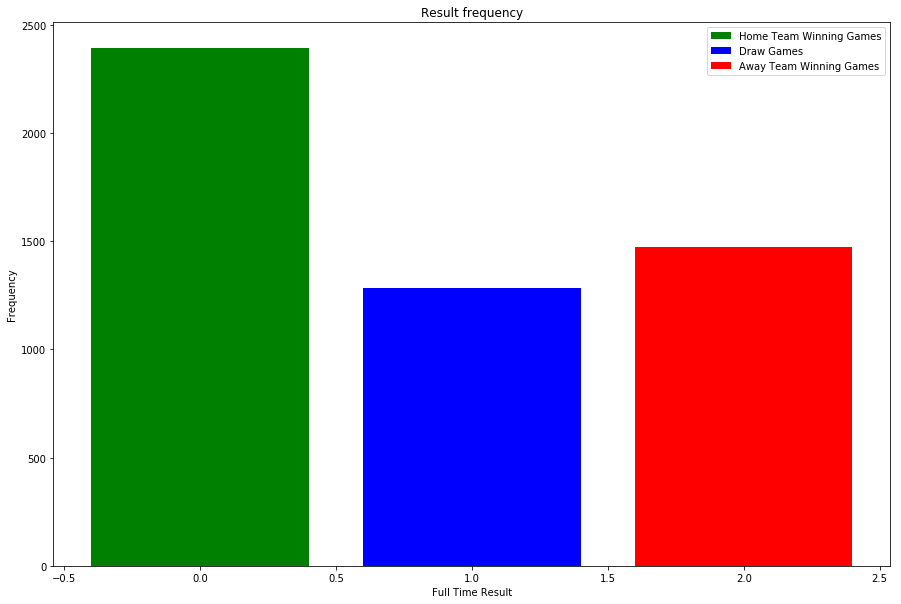

<Figure size 432x288 with 0 Axes>

In [10]:
plt.figure(figureNum, figsize=(15,10))

#plot bar graph
plt.bar(ftrHome.keys(), ftrHome.values(), color = "g" , label = "Home Team Winning Games")
plt.bar(ftrDraw.keys(), ftrDraw.values(), color = "b" , label = "Draw Games")
plt.bar(ftrAway.keys(), ftrAway.values(), color = "r" , label = "Away Team Winning Games")
plt.xlabel('Full Time Result') 
plt.ylabel('Frequency') 
plt.legend() 
plt.title('Result frequency')

#show and iterate graph, and clear configurations for reliability
plt.show()
plt.gcf().clear()
figureNum += 1

**Result frequency**

It can be seen that home team wins are the majority followed by away team wins. This is a bias that needed to be removed from the data. However this bias is not nessessary be bad as it can be considered as a feature, we will elaborate on this when we train our model.

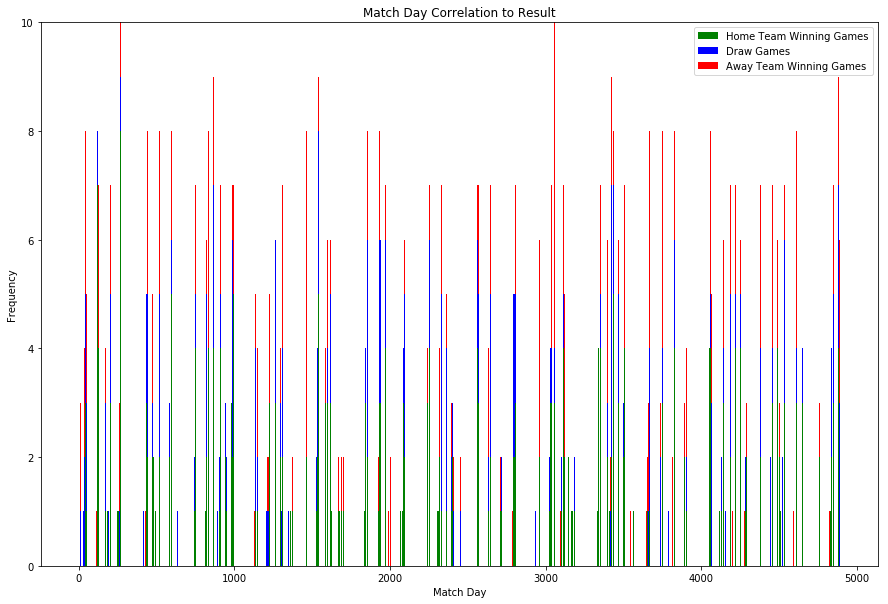

<Figure size 432x288 with 0 Axes>

In [11]:
plt.figure(figureNum, figsize=(15,10))

#convert dictionaries to arrays for handling stacked bar charts
h=[]
d=[]
for key, val in dayHome.items():
    h.append(val)
for key, val in dayDraw.items():
    d.append(val)
h=np.array(h)
d=np.array(d)

#plot stacked bar charts
plt.bar(dayHome.keys(), dayHome.values(), color = "g" , label = "Home Team Winning Games")
plt.bar(dayDraw.keys(), dayDraw.values(), bottom = h, color = "b" , label = "Draw Games")
plt.bar(dayAway.keys(), dayAway.values(), bottom = h+d, color = "r" , label = "Away Team Winning Games")

#labels
plt.xlabel('Match Day') 
plt.ylabel('Frequency') 
plt.legend() 
plt.title('Match Day Correlation to Result')

#show and iterate graph, and clear configurations for reliability
plt.show()
plt.gcf().clear()
figureNum += 1

**Match Day Correlation to Result**

The graph suggests that there are periods where more games result in draws as seen by the blue. These seem to occur a near a little between gaps in seasons and may be indicative of periods where teams may be less concerned with scoring significant points, being content with the current league position. Home wins also tends to be highest near the middle of blocks where matches occur and may indicate when teams get accustomed to playing and are therefore have higher chances of winning. Correlation to result is limited but date information may also be useful in indirect relationships where recent results are more useful.

ValueError: shape mismatch: objects cannot be broadcast to a single shape

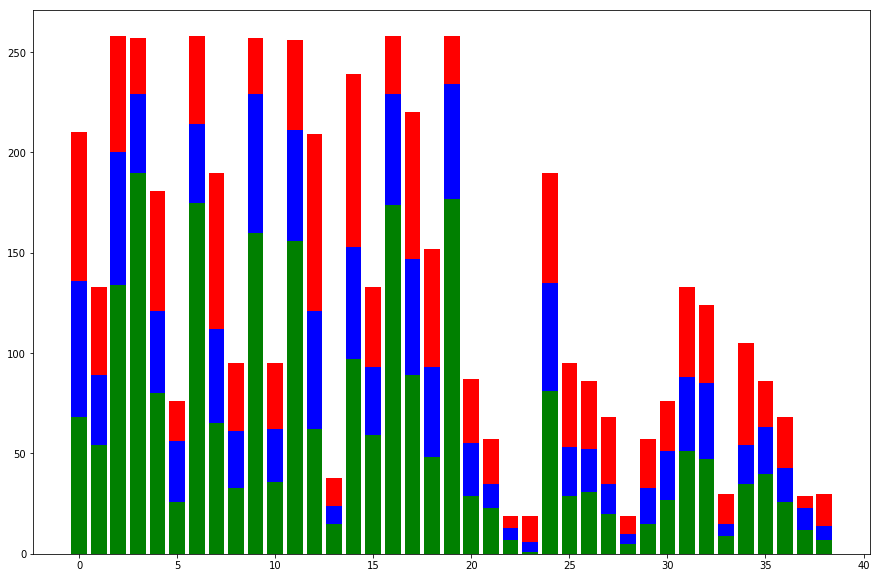

In [12]:
plt.figure(figureNum, figsize=(15,10))

#convert dictionaries to arrays for handling stacked bar charts
h=[]
d=[]
for key, val in homeTeamHome.items():
    h.append(val)
for key, val in homeTeamDraw.items():
    d.append(val)
h=np.array(h)
d=np.array(d)

#plot stacked bar charts
plt.bar(homeTeamHome.keys(), homeTeamHome.values(), color = "g" , label = "Home Team Winning Games")
plt.bar(homeTeamDraw.keys(), homeTeamDraw.values(), bottom = h, color = "b" , label = "Draw Games")
plt.bar(homeTeamAway.keys(), homeTeamAway.values(), bottom = h+d, color = "r" , label = "Away Team Winning Games")

plt.bar(dayAway.keys(), dayAway.values(), bottom = h+d, color = "r" , label = "Away Team Winning Games")

#labels
plt.xlabel('Home Team') 
plt.ylabel('Frequency') 
plt.legend() 
plt.title('Home Team Correlation to Result')

#show graph and clear
plt.show()
plt.gcf().clear()
figureNum += 1

**Home Team Correlation to Result**

It can be seen that some teams are more likely to win home games than others, suggesting certain teams are inherently more likely to win. The same can be said of draws occurring and these often coincide with strong teams although there are differences between teams. For example 7 and 11, where 7 had a lower tendency to draw despite similar ratios of wins and losses. It also appears home teams are more likely to win than not.

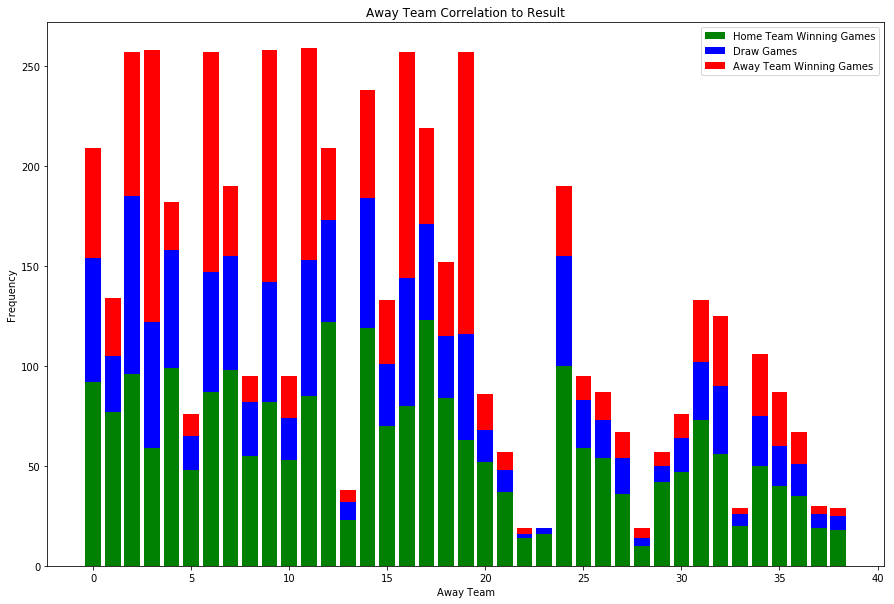

<Figure size 432x288 with 0 Axes>

In [13]:
plt.figure(figureNum, figsize=(15,10))

#convert dictionaries to arrays for handling stacked bar charts
h=[]
d=[]
for key, val in awayTeamHome.items():
    h.append(val)
for key, val in awayTeamDraw.items():
    d.append(val)
h=np.array(h)
d=np.array(d)

#plot stacked bar charts
plt.bar(awayTeamHome.keys(), awayTeamHome.values(), color = "g" , label = "Home Team Winning Games")
plt.bar(awayTeamDraw.keys(), awayTeamDraw.values(), bottom = h, color = "b" , label = "Draw Games")
plt.bar(awayTeamAway.keys(), awayTeamAway.values(), bottom = h+d, color = "r" , label = "Away Team Winning Games")

#labels
plt.xlabel('Away Team') 
plt.ylabel('Frequency') 
plt.legend() 
plt.title('Away Team Correlation to Result')

#show graph and clear
plt.show()
plt.gcf().clear()
figureNum += 1

**Away Team Correlation to Result**

This graph differs considerably with the home team graph, showing a clear home advantage effect. Since home teams are random in this graph and home wins are relatively consistent, it suggests that a significant factor in match results is due to the away teams' ability to overcome the home advantage. Teams' affinity for loss or draws are also evident in this graph.

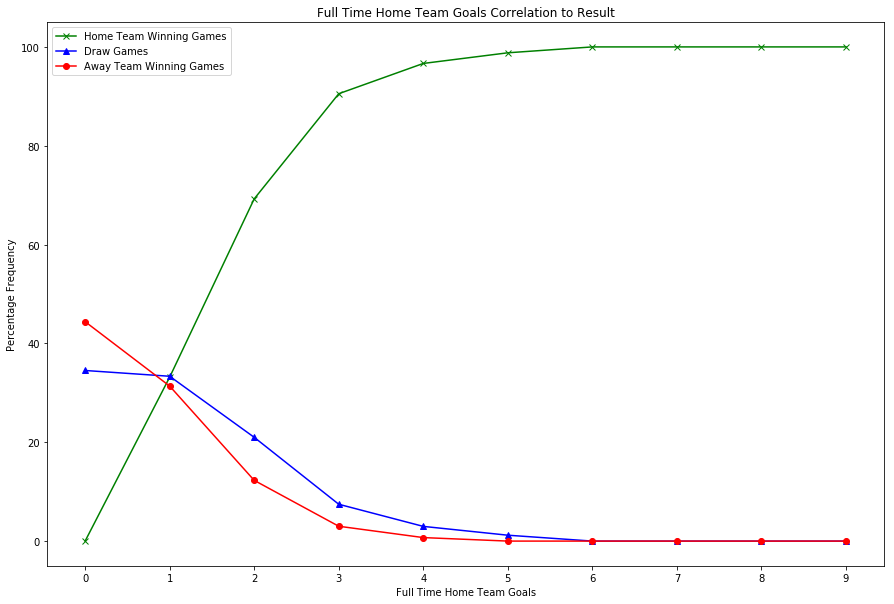

<Figure size 432x288 with 0 Axes>

In [14]:
plt.figure(figureNum, figsize=(15,10))

#plot ordering by key values
plt.plot(sorted(fthgHome, key=float), [value for (key, value) in sorted(fthgHome.items())], marker = 'x', color = "g" , label = "Home Team Winning Games")
plt.plot(sorted(fthgDraw, key=float), [value for (key, value) in sorted(fthgDraw.items())], marker = '^', color = "b" , label = "Draw Games")
plt.plot(sorted(fthgAway, key=float), [value for (key, value) in sorted(fthgAway.items())], marker = 'o', color = "r" , label = "Away Team Winning Games")

#labels
plt.xlabel('Full Time Home Team Goals') 
plt.ylabel('Percentage Frequency') 
plt.legend() 
plt.title('Full Time Home Team Goals Correlation to Result')

#show graph and clear
plt.show()
plt.gcf().clear()
figureNum += 1

**Full Time Home Team Goals Correlation to Result**

It is clear there is a logarithmic correlation between winning and goals scored.

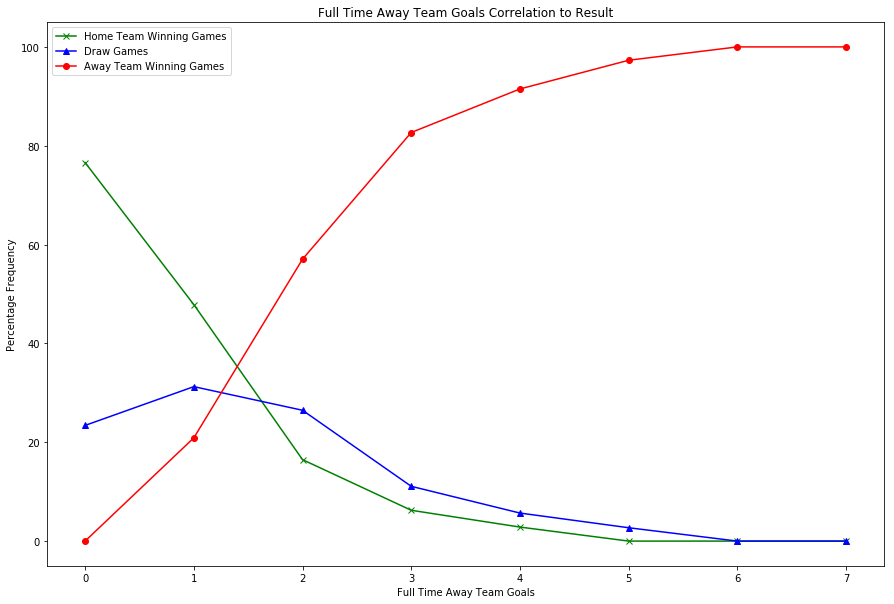

<Figure size 432x288 with 0 Axes>

In [15]:
plt.figure(figureNum, figsize=(15,10))

#plot
plt.plot(sorted(ftagHome, key=float), [value for (key, value) in sorted(ftagHome.items())], marker = 'x', color = "g" , label = "Home Team Winning Games")
plt.plot(sorted(ftagDraw, key=float), [value for (key, value) in sorted(ftagDraw.items())], marker = '^', color = "b" , label = "Draw Games")
plt.plot(sorted(ftagAway, key=float), [value for (key, value) in sorted(ftagAway.items())], marker = 'o', color = "r" , label = "Away Team Winning Games")

#labels
plt.xlabel('Full Time Away Team Goals') 
plt.ylabel('Percentage Frequency') 
plt.legend() 
plt.title('Full Time Away Team Goals Correlation to Result')

#show graph and clear
plt.show()
plt.gcf().clear()
figureNum += 1

**Full Time Away Team Goals Correlation to Result**

It is clear there is a logarithmic correlation between winning and goals scored.

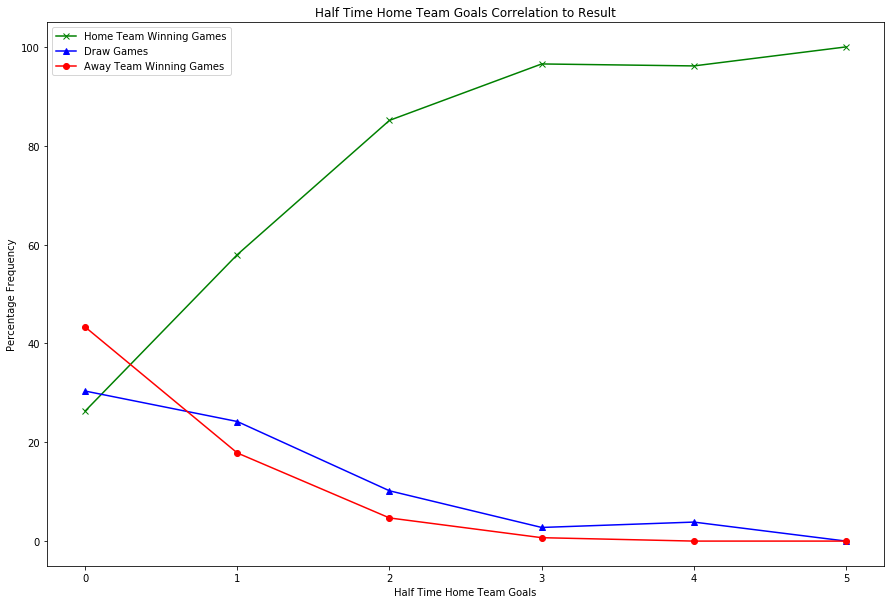

<Figure size 432x288 with 0 Axes>

In [16]:
plt.figure(figureNum, figsize=(15,10))

#plot
plt.plot(sorted(hthgHome, key=float), [value for (key, value) in sorted(hthgHome.items())], marker = 'x', color = "g" , label = "Home Team Winning Games")
plt.plot(sorted(hthgDraw, key=float), [value for (key, value) in sorted(hthgDraw.items())], marker = '^', color = "b" , label = "Draw Games")
plt.plot(sorted(hthgAway, key=float), [value for (key, value) in sorted(hthgAway.items())], marker = 'o', color = "r" , label = "Away Team Winning Games")

#labels
plt.xlabel('Half Time Home Team Goals') 
plt.ylabel('Percentage Frequency') 
plt.legend() 
plt.title('Half Time Home Team Goals Correlation to Result')

#show graph and clear
plt.show()
plt.gcf().clear()
figureNum += 1

**Half Time Home Team Goals Correlation to Result**

The relationship between goals scored and result is a less clear for half time goals compared to full time.

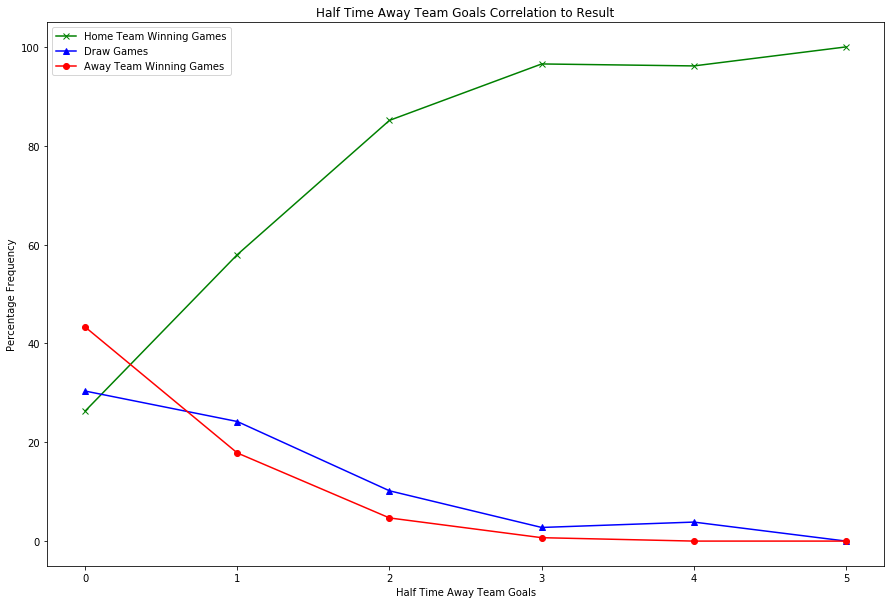

<Figure size 432x288 with 0 Axes>

In [17]:
plt.figure(figureNum, figsize=(15,10))

#plot
plt.plot(sorted(htagHome, key=float), [value for (key, value) in sorted(htagHome.items())], marker = 'x', color = "g" , label = "Home Team Winning Games")
plt.plot(sorted(htagDraw, key=float), [value for (key, value) in sorted(htagDraw.items())], marker = '^', color = "b" , label = "Draw Games")
plt.plot(sorted(htagAway, key=float), [value for (key, value) in sorted(htagAway.items())], marker = 'o', color = "r" , label = "Away Team Winning Games")

#labels
plt.xlabel('Half Time Away Team Goals') 
plt.ylabel('Percentage Frequency') 
plt.legend() 
plt.title('Half Time Away Team Goals Correlation to Result')

#show graph and clear
plt.show()
plt.gcf().clear()
figureNum += 1

**Half Time Away Team Goals Correlation to Result**

The relationship between goals scored and result is a less clear for half time goals compared to full time.

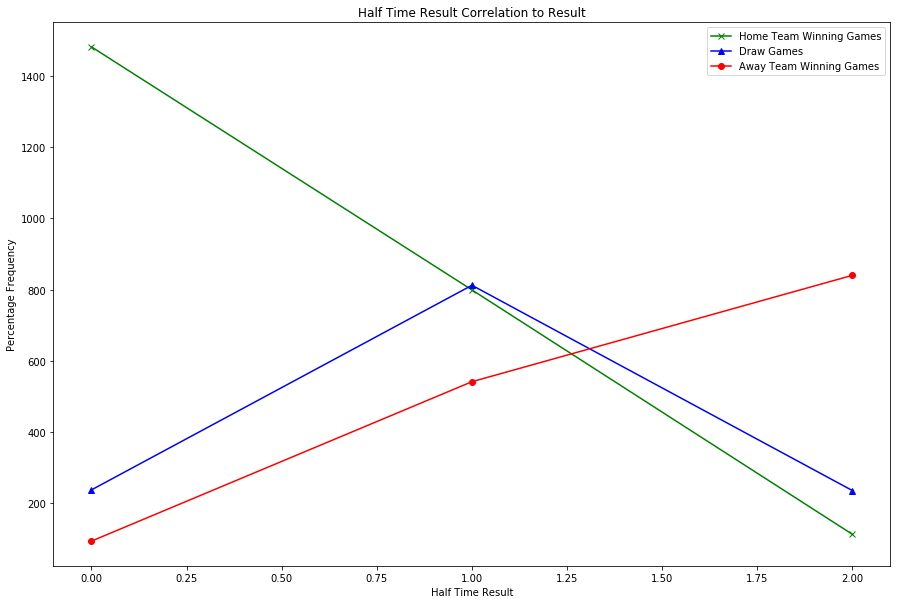

<Figure size 432x288 with 0 Axes>

In [18]:
plt.figure(figureNum, figsize=(15,10))

#plot
plt.plot(sorted(htrHome, key=float), [value for (key, value) in sorted(htrHome.items())], marker = 'x', color = "g" , label = "Home Team Winning Games")
plt.plot(sorted(htrDraw, key=float), [value for (key, value) in sorted(htrDraw.items())], marker = '^', color = "b" , label = "Draw Games")
plt.plot(sorted(htrAway, key=float), [value for (key, value) in sorted(htrAway.items())], marker = 'o', color = "r" , label = "Away Team Winning Games")

#labels
plt.xlabel('Half Time Result') 
plt.ylabel('Percentage Frequency') 
plt.legend() 
plt.title('Half Time Result Correlation to Result')

#show graph and clear
plt.show()
plt.gcf().clear()
figureNum += 1

**Half Time Result Correlation to Result**

The half time result seems to correlate linearly with the full time result as expected. There appears to be a difference being that away teams' lead at half time is less likely to be maintained, possibly due to home crowds cheeering to encourage the home side. It is also clear home teams have an advantage with more better results.

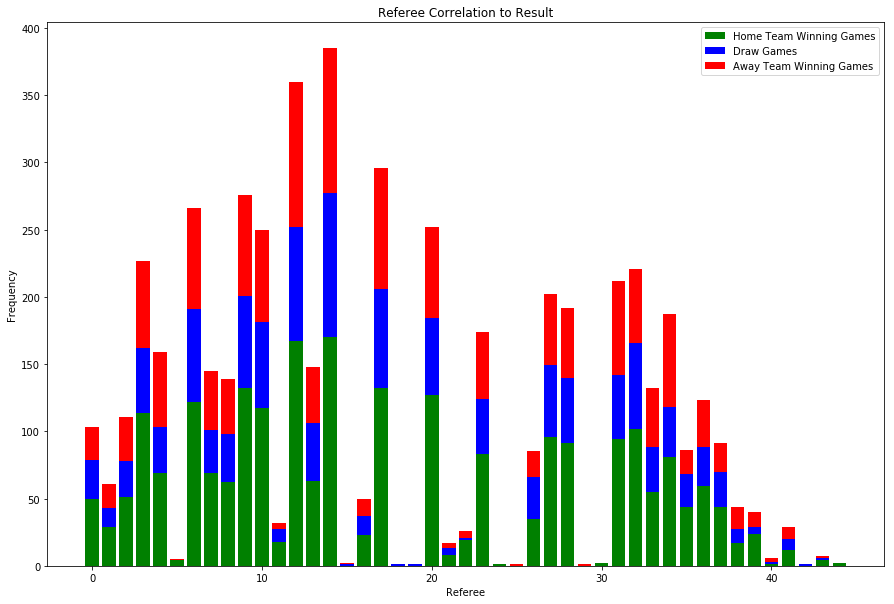

<Figure size 432x288 with 0 Axes>

In [19]:
plt.figure(figureNum, figsize=(15,10))

#convert dictionaries to arrays for handling stacked bar charts
h=[]
d=[]
for key, val in refereeHome.items():
    h.append(val)
for key, val in refereeDraw.items():
    d.append(val)
h=np.array(h)
d=np.array(d)

#plot stacked bar charts
plt.bar(refereeHome.keys(), refereeHome.values(), color = "g" , label = "Home Team Winning Games")
plt.bar(refereeDraw.keys(), refereeDraw.values(), bottom = h, color = "b" , label = "Draw Games")
plt.bar(refereeAway.keys(), refereeAway.values(), bottom = h+d, color = "r" , label = "Away Team Winning Games")

#labels
plt.xlabel('Referee') 
plt.ylabel('Frequency') 
plt.legend() 
plt.title('Referee Correlation to Result')

#show graph and clear
plt.show()
plt.gcf().clear()
figureNum += 1

**Referee Correlation to Result**

Referee's appear to have minimal impact on games. Referees that are involved in less games may seem to favour home teams, but this relationship cannot be certain due to being in small numbers of matches and the home teams being more likely to win overall.

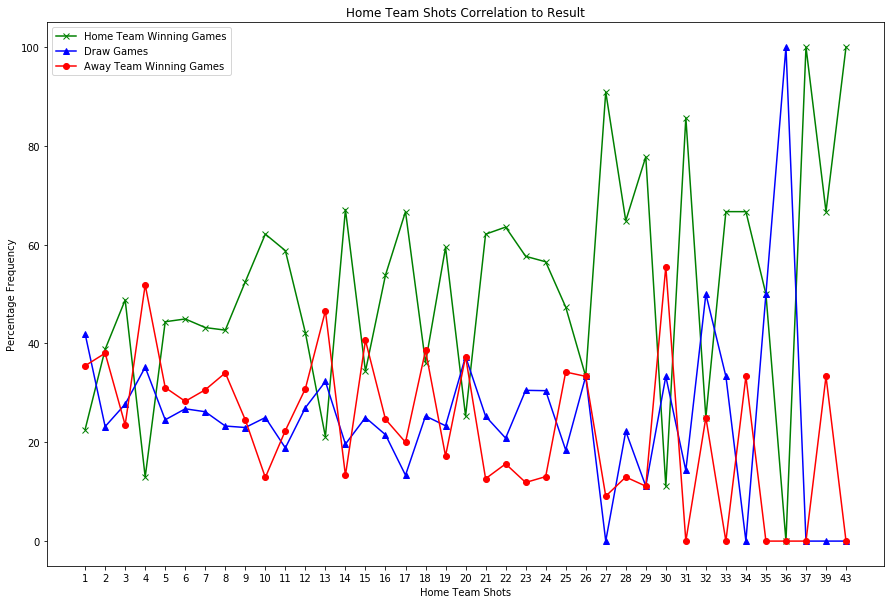

<Figure size 432x288 with 0 Axes>

In [20]:
plt.figure(figureNum, figsize=(15,10))

#plot
plt.plot(sorted(hsHome, key=float), [value for (key, value) in hsHome.items()], marker = 'x', color = "g" , label = "Home Team Winning Games")
plt.plot(sorted(hsDraw, key=float), [value for (key, value) in hsDraw.items()], marker = '^', color = "b" , label = "Draw Games")
plt.plot(sorted(hsAway, key=float), [value for (key, value) in hsAway.items()], marker = 'o', color = "r" , label = "Away Team Winning Games")

#labels
plt.xlabel('Home Team Shots') 
plt.ylabel('Percentage Frequency') 
plt.legend() 
plt.title('Home Team Shots Correlation to Result')

#show graph and clear
plt.show()
plt.gcf().clear()
figureNum += 1

**Home Team Shots Correlation to Result**

From the graph it can be seen that as shots from the home team increase. The relationship also becomes less clear after 30 shots. These suggest that when the home team takes around 30 shots a game, the home team may have become desperate and shooting blindly causing variation in the data.

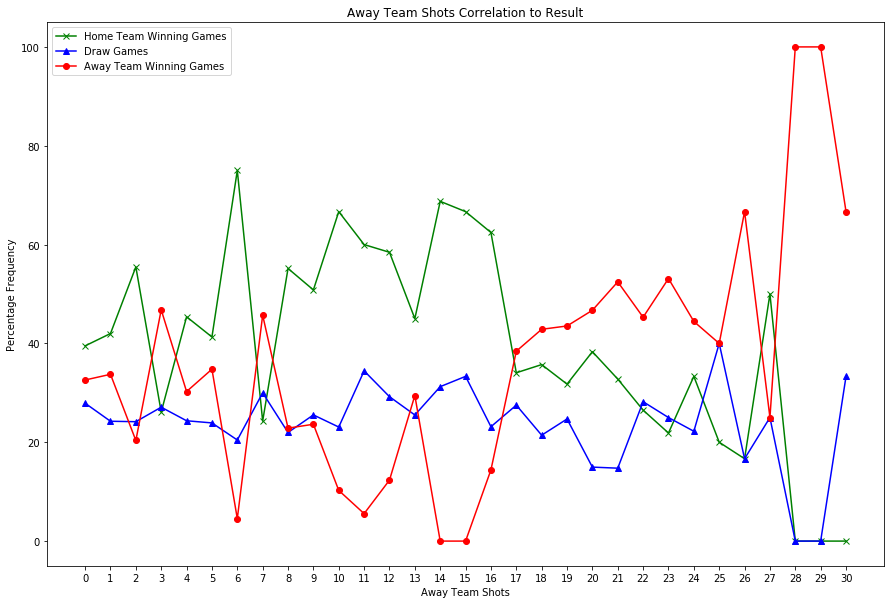

<Figure size 432x288 with 0 Axes>

In [21]:
plt.figure(figureNum, figsize=(15,10))

#plot
plt.plot(sorted(aShotsHome, key=float), [value for (key, value) in aShotsHome.items()], marker = 'x', color = "g" , label = "Home Team Winning Games")
plt.plot(sorted(aShotsDraw, key=float), [value for (key, value) in aShotsDraw.items()], marker = '^', color = "b" , label = "Draw Games")
plt.plot(sorted(aShotsAway, key=float), [value for (key, value) in aShotsAway.items()], marker = 'o', color = "r" , label = "Away Team Winning Games")

#labels
plt.xlabel('Away Team Shots') 
plt.ylabel('Percentage Frequency') 
plt.legend() 
plt.title('Away Team Shots Correlation to Result')

#show graph and clear
plt.show()
plt.gcf().clear()
figureNum += 1

**Away Team Shots Correlation to Result**

From the graph it can be seen that as shots from the away team increase, away team win rate increases after 16 shots. These suggest that when the away team unlike the home team, requires more shots before a noticeable increase in win chance occurs. This suggests the model should treat home and away matches differently for the teams.

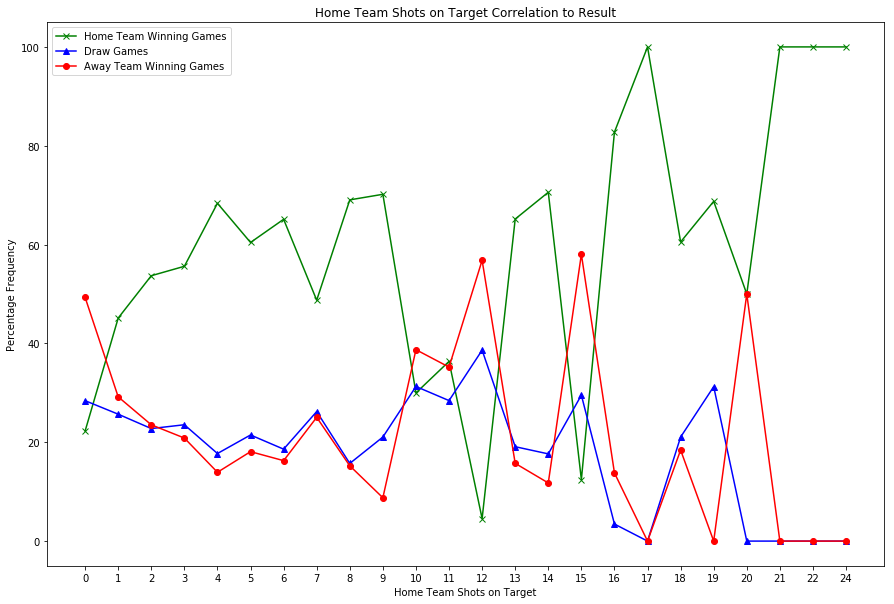

<Figure size 432x288 with 0 Axes>

In [22]:
plt.figure(figureNum, figsize=(15,10))

#plot
plt.plot(sorted(hstHome, key=float), [value for (key, value) in (hstHome.items())], marker = 'x', color = "g" , label = "Home Team Winning Games")
plt.plot(sorted(hstDraw, key=float), [value for (key, value) in (hstDraw.items())], marker = '^', color = "b" , label = "Draw Games")
plt.plot(sorted(hstAway, key=float), [value for (key, value) in (hstAway.items())], marker = 'o', color = "r" , label = "Away Team Winning Games")

#labels
plt.xlabel('Home Team Shots on Target') 
plt.ylabel('Percentage Frequency') 
plt.legend() 
plt.title('Home Team Shots on Target Correlation to Result')

#show graph and clear
plt.show()
plt.gcf().clear()
figureNum += 1

**Home Team Shots on Target Correlation to Result**

A similar trend occurs with shots on target compared to shots. The variation now begins at a lower value around 10 shots. The same trend is expected since a proportion of shots is the shots on target. The variation is reduced, possibly due to random 'pot' shots being less likely to be on target.

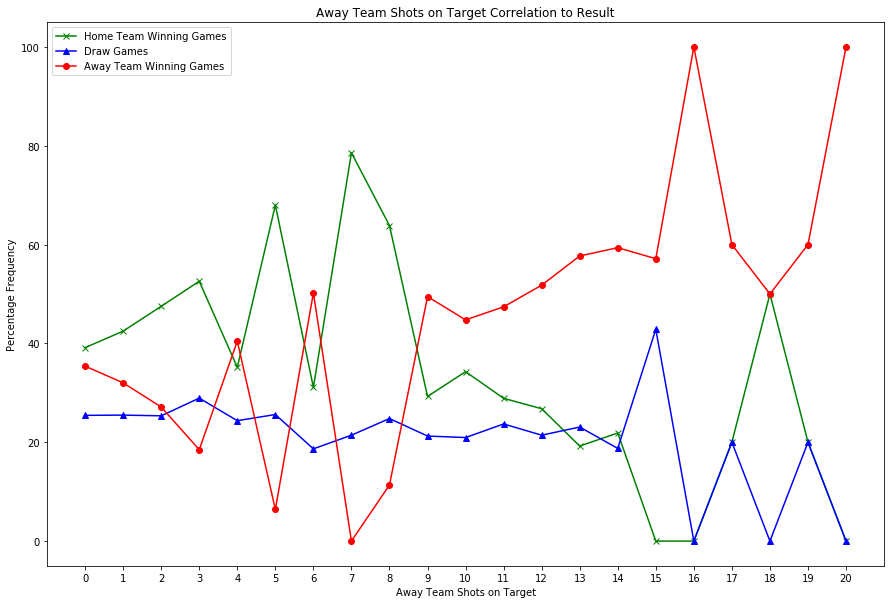

<Figure size 432x288 with 0 Axes>

In [23]:
plt.figure(figureNum, figsize=(15,10))

#plot
plt.plot(sorted(astHome, key=float), [value for (key, value) in (astHome.items())], marker = 'x', color = "g" , label = "Home Team Winning Games")
plt.plot(sorted(astDraw, key=float), [value for (key, value) in (astDraw.items())], marker = '^', color = "b" , label = "Draw Games")
plt.plot(sorted(astAway, key=float), [value for (key, value) in (astAway.items())], marker = 'o', color = "r" , label = "Away Team Winning Games")

#labels
plt.xlabel('Away Team Shots on Target') 
plt.ylabel('Percentage Frequency') 
plt.legend() 
plt.title('Away Team Shots on Target Correlation to Result')

#show graph and clear
plt.show()
plt.gcf().clear()
figureNum += 1

**Away Team Shots on Target Correlation to Result**

A similar trend occurs with shots on target compared to shots. The variation now begins at a lower value around 9 shots. The same trend is expected since a proportion of shots is the shots on target.

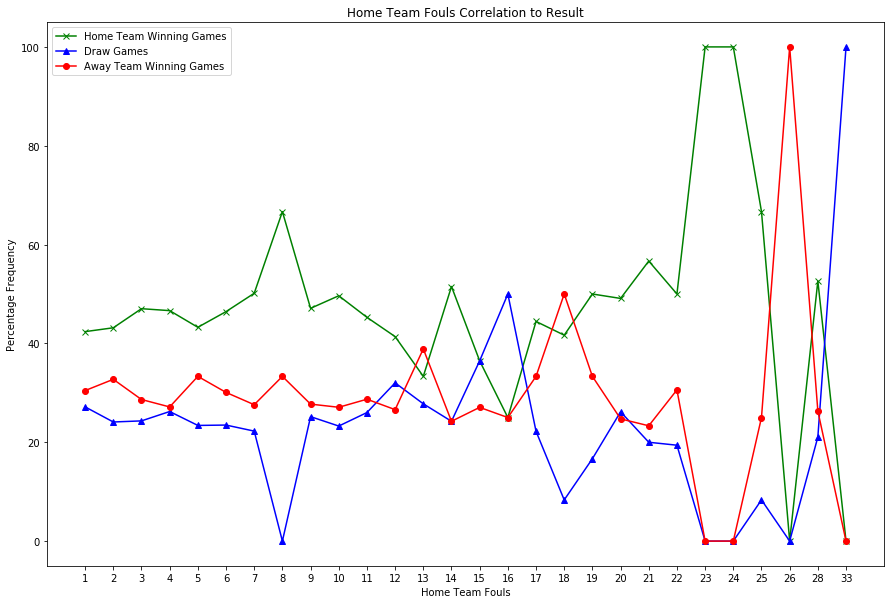

<Figure size 432x288 with 0 Axes>

In [24]:
plt.figure(figureNum, figsize=(15,10))

#plot
plt.plot(sorted(hfHome, key=float), [value for (key, value) in (hfHome.items())], marker = 'x', color = "g" , label = "Home Team Winning Games")
plt.plot(sorted(hfDraw, key=float), [value for (key, value) in (hfDraw.items())], marker = '^', color = "b" , label = "Draw Games")
plt.plot(sorted(hfAway, key=float), [value for (key, value) in (hfAway.items())], marker = 'o', color = "r" , label = "Away Team Winning Games")

#labels
plt.xlabel('Home Team Fouls') 
plt.ylabel('Percentage Frequency') 
plt.legend() 
plt.title('Home Team Fouls Correlation to Result')

#show graph and clear
plt.show()
plt.gcf().clear()
figureNum += 1

**Home Team Fouls Correlation to Result**

Fouls do not seem to have significant direct impact on the game results.

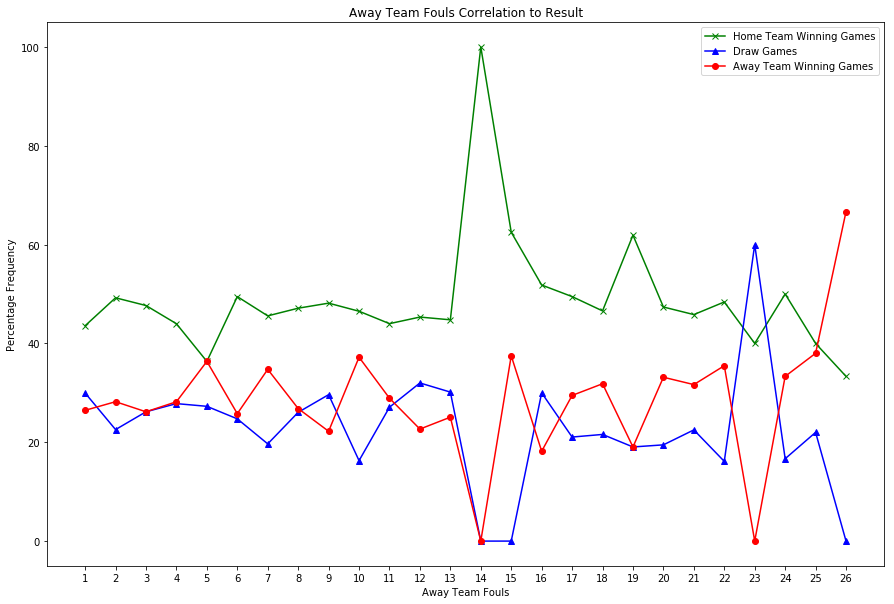

<Figure size 432x288 with 0 Axes>

In [25]:
plt.figure(figureNum, figsize=(15,10))

#plot
plt.plot(sorted(afHome, key=float), [value for (key, value) in (afHome.items())], marker = 'x', color = "g" , label = "Home Team Winning Games")
plt.plot(sorted(afDraw, key=float), [value for (key, value) in (afDraw.items())], marker = '^', color = "b" , label = "Draw Games")
plt.plot(sorted(afAway, key=float), [value for (key, value) in (afAway.items())], marker = 'o', color = "r" , label = "Away Team Winning Games")

#labels
plt.xlabel('Away Team Fouls') 
plt.ylabel('Percentage Frequency') 
plt.legend() 
plt.title('Away Team Fouls Correlation to Result')

#show graph and clear
plt.show()
plt.gcf().clear()
figureNum += 1

**Away Team Fouls Correlation to Result**

Fouls do not seem to have significant direct impact on the game results.

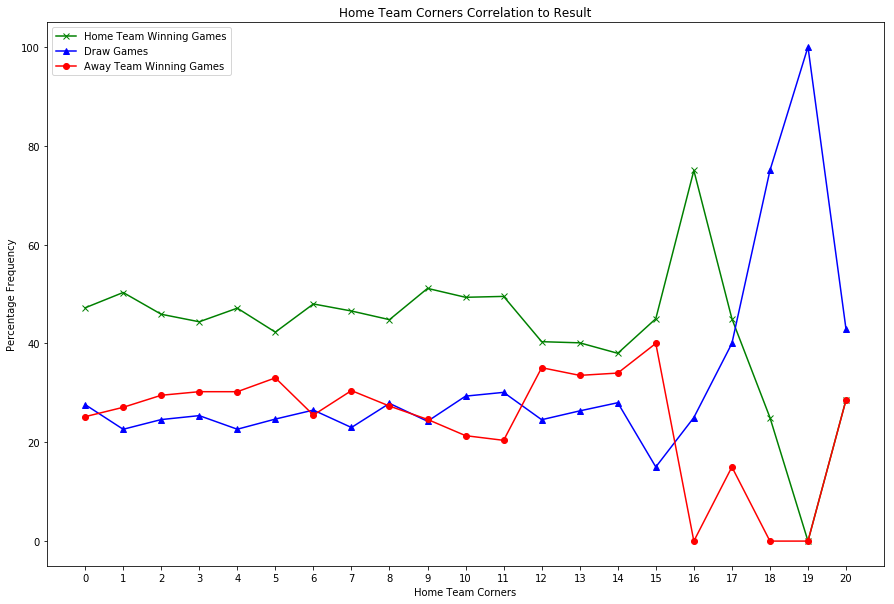

<Figure size 432x288 with 0 Axes>

In [26]:
plt.figure(figureNum, figsize=(15,10))

#plot
plt.plot(sorted(hcHome, key=float), [value for (key, value) in (hcHome.items())], marker = 'x', color = "g" , label = "Home Team Winning Games")
plt.plot(sorted(hcDraw, key=float), [value for (key, value) in (hcDraw.items())], marker = '^', color = "b" , label = "Draw Games")
plt.plot(sorted(hcAway, key=float), [value for (key, value) in (hcAway.items())], marker = 'o', color = "r" , label = "Away Team Winning Games")

#labels
plt.xlabel('Home Team Corners') 
plt.ylabel('Percentage Frequency') 
plt.legend() 
plt.title('Home Team Corners Correlation to Result')

#show graph and clear
plt.show()
plt.gcf().clear()
figureNum += 1

**Home Team Corners Correlation to Result**

Corners do not seem to have significant direct impact on the game results.

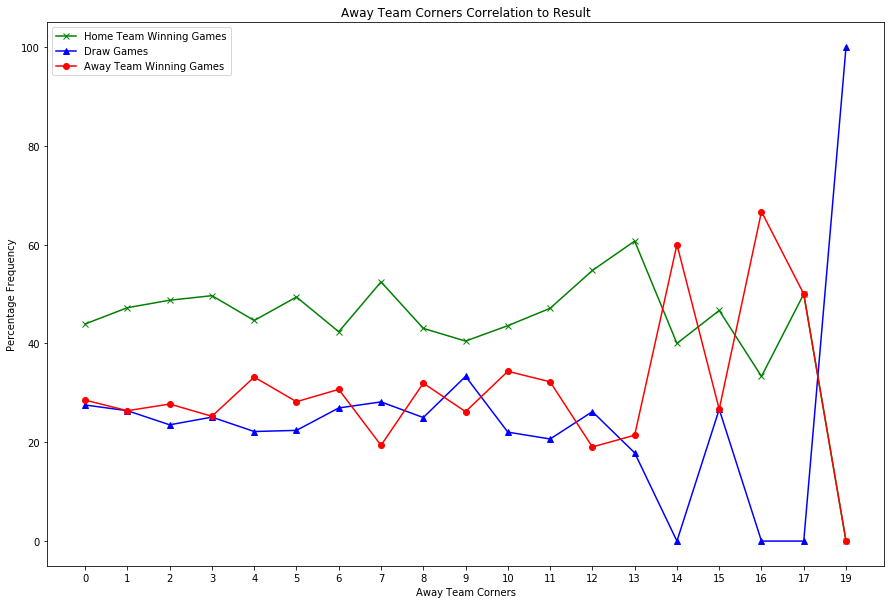

<Figure size 432x288 with 0 Axes>

In [27]:
plt.figure(figureNum, figsize=(15,10))

#plot
plt.plot(sorted(acHome, key=float), [value for (key, value) in (acHome.items())], marker = 'x', color = "g" , label = "Home Team Winning Games")
plt.plot(sorted(acDraw, key=float), [value for (key, value) in (acDraw.items())], marker = '^', color = "b" , label = "Draw Games")
plt.plot(sorted(acAway, key=float), [value for (key, value) in (acAway.items())], marker = 'o', color = "r" , label = "Away Team Winning Games")

#labels
plt.xlabel('Away Team Corners') 
plt.ylabel('Percentage Frequency') 
plt.legend() 
plt.title('Away Team Corners Correlation to Result')

#show graph and clear
plt.show()
plt.gcf().clear()
figureNum += 1

**Away Team Corners Correlation to Result**

Corners do not seem to have significant direct impact on the game results.

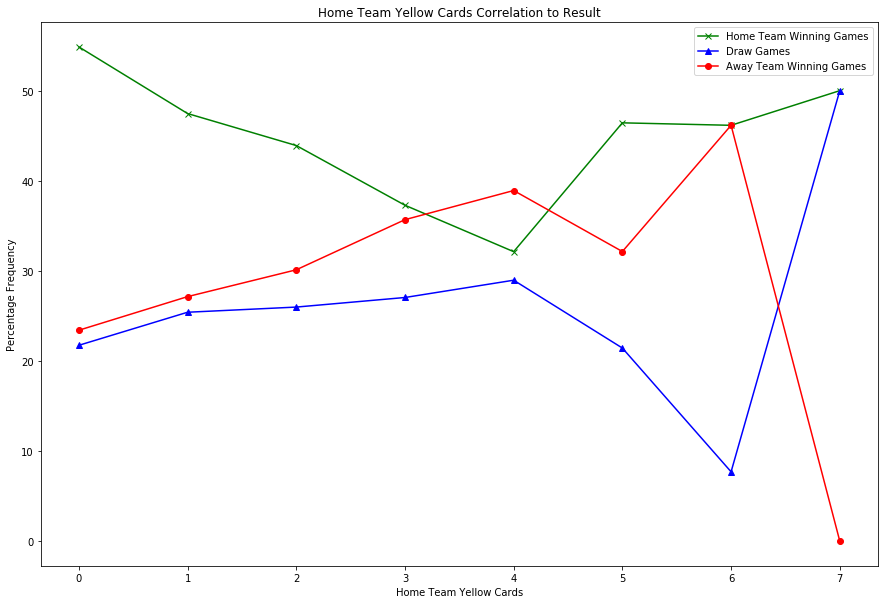

<Figure size 432x288 with 0 Axes>

In [28]:
plt.figure(figureNum, figsize=(15,10))

#plot
plt.plot(sorted(hyHome), [value for (key, value) in sorted(hyHome.items())], marker = 'x', color = "g" , label = "Home Team Winning Games")
plt.plot(sorted(hyDraw), [value for (key, value) in sorted(hyDraw.items())], marker = '^', color = "b" , label = "Draw Games")
plt.plot(sorted(hyAway), [value for (key, value) in sorted(hyAway.items())], marker = 'o', color = "r" , label = "Away Team Winning Games")

#labels
plt.xlabel('Home Team Yellow Cards') 
plt.ylabel('Percentage Frequency') 
plt.legend() 
plt.title('Home Team Yellow Cards Correlation to Result')

#show graph and clear
plt.show()
plt.gcf().clear()
figureNum += 1

**Home Team Yellow Cards Correlation to Result**

Yellow cards seem to correlate linearly with away team winning (anomalous point of 7 yellow cards from two match which is statistically insignificant).

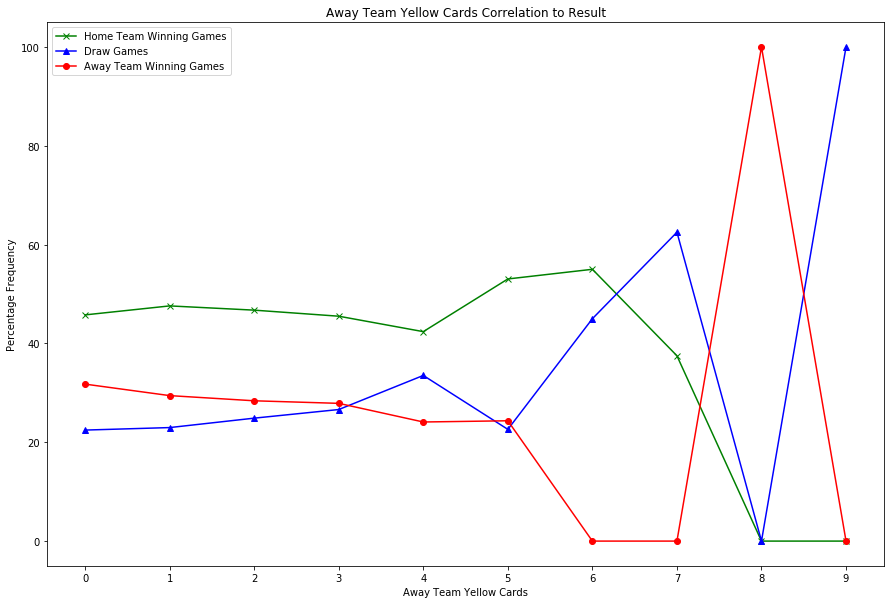

<Figure size 432x288 with 0 Axes>

In [29]:
plt.figure(figureNum, figsize=(15,10))

#plot
plt.plot(sorted(ayHome), [value for (key, value) in sorted(ayHome.items())], marker = 'x', color = "g" , label = "Home Team Winning Games")
plt.plot(sorted(ayDraw), [value for (key, value) in sorted(ayDraw.items())], marker = '^', color = "b" , label = "Draw Games")
plt.plot(sorted(ayAway), [value for (key, value) in sorted(ayAway.items())], marker = 'o', color = "r" , label = "Away Team Winning Games")

#labels
plt.xlabel('Away Team Yellow Cards') 
plt.ylabel('Percentage Frequency') 
plt.legend() 
plt.title('Away Team Yellow Cards Correlation to Result')

#show graph and clear
plt.show()
plt.gcf().clear()
figureNum += 1

**Away Team Yellow Cards Correlation to Result**

Yellow cards from the away team seem to correlate with more draws. This differs from home team yellow cards, further emphasising the difference in home and away team effects.

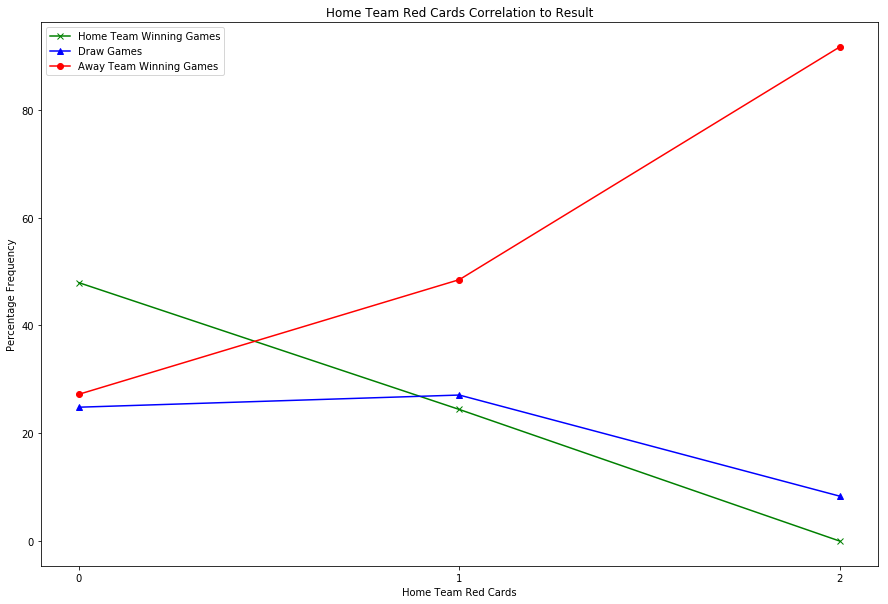

<Figure size 432x288 with 0 Axes>

In [30]:
plt.figure(figureNum, figsize=(15,10))

#plot
plt.plot(sorted(hrHome), [value for (key, value) in sorted(hrHome.items())], marker = 'x', color = "g" , label = "Home Team Winning Games")
plt.plot(sorted(hrDraw), [value for (key, value) in sorted(hrDraw.items())], marker = '^', color = "b" , label = "Draw Games")
plt.plot(sorted(hrAway), [value for (key, value) in sorted(hrAway.items())], marker = 'o', color = "r" , label = "Away Team Winning Games")

#labels
plt.xlabel('Home Team Red Cards') 
plt.ylabel('Percentage Frequency') 
plt.legend() 
plt.title('Home Team Red Cards Correlation to Result')

#show graph and clear
plt.show()
plt.gcf().clear()
figureNum += 1

**Home Team Red Cards Correlation to Result**

Red cards seem to correlate exponentially with opposing teams winning, as would be expected.

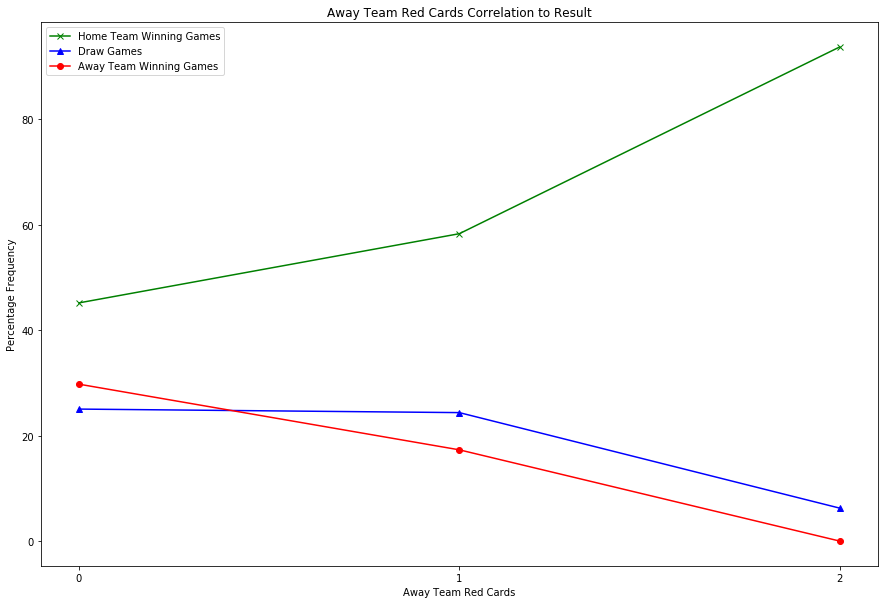

<Figure size 432x288 with 0 Axes>

In [31]:
plt.figure(figureNum, figsize=(15,10))

#plot
plt.plot(sorted(arHome), [value for (key, value) in sorted(arHome.items())], marker = 'x', color = "g" , label = "Home Team Winning Games")
plt.plot(sorted(arDraw), [value for (key, value) in sorted(arDraw.items())], marker = '^', color = "b" , label = "Draw Games")
plt.plot(sorted(arAway), [value for (key, value) in sorted(arAway.items())], marker = 'o', color = "r" , label = "Away Team Winning Games")

#labels
plt.xlabel('Away Team Red Cards') 
plt.ylabel('Percentage Frequency') 
plt.legend() 
plt.title('Away Team Red Cards Correlation to Result')

#show graph and clear
plt.show()
plt.gcf().clear()
figureNum += 1

**Away Team Red Cards Correlation to Result**

Red cards seem to correlate exponentially with opposing teams winning, as would be expected.

# Conclusion and Approach
Our approach are condensated from multiple papers that achieved some decent accuracy. We used the idea of using virtual data as attributes for representation of each team's abilities, assuming no human bias are involved anytime.

As we assumed there are no human bias, we can focus on the features that affect each team's abilities in which from (Shin,J, Gasparyan,R, A novel way to Soccer Match Prediction, Stanford), the comparision of using real data and virtual data to train giving us an idea of using both data to train, promptly giving a better chance in classification of the data. From this idea, we explore both data furthermore in order to find extra correlation.

After exploration, we divide each of our feature into three categories, Strategy, Attack and Defense. The Strategy includes the form of the team for each match. As from (Gevaria,K, Sanghavi,H, Vaidya,S, Deulkar,K, (2015), Football Match Winner Prediction, International Journal of Emerging Technology and Advanced Engineering Vol.t, Issue 10), we know that we can use the provided data to calculate the simplest indication of form is the hot streak of each team. Attack includes all the attack categories in the virtual data along with the number of goals, shot, assist in the game while defense include the number of fouls, corners and team's clean sheet. 

However, in our exploration, we did not find a linear relation between the number of fouls, corners. As we have prior belief in these features, it is likely that there are non-linear relation that will explain the correlation. Acting on our belief and from Gevaria paper, we still include the number of fouls and corners into our data.

As we move on, we used one hot encoder as a mean of encode categorised team name which increase the number of features to over 70 as there are over 30 teams, increasing the training time and potentially overfitting our model. It is possible to remove the team name from our training data as the model is learning to categorise from our features, including the team name would include a bias saying that when team A is always win against team B, there will be higher chance of team A win against team B. This bias can be undesirable when predicting similar strength team, motivating us to remove the bias by removing the team name, decreasing potential overfitting and training time.

In order to process the data, we showed a feature list below which is seasonal average of the provided data and the average rating in multiple categories in virtual data. The collection and processing of data is showed below.


# Features and Method

Using the modified training data we will implement the following features which is motivated through the exploration and transformation of data.  
<br>
<br>
Home team - Which team is home, teams were presented in a one hot encoded fashion.
<br>
Away team - Which team is away, teams were presented in a one hot encoded fashion.
<br>
Home goal per game.
<br>
Away goal per game.
<br>
Home shots per game.
<br>
Away shots per game.
<br>
Home shots on target per game.
<br>
Away shots on target per game.
<br>
Home fouls per game.
<br>
Away fouls per game.
<br>
Home corners per game.
<br>
Away corners per game.
<br>
Home average goal differential. 
<br>
Away average goal differential. 
<br>
Home clean sheets. 
<br>
Away clean sheets.
<br>
Home team hot streak number of games won since last loss.
<br>
Away team hot streak number of games won since last loss.
<br>
<br>
These features will be calculated on a seasonal bases so that we take into account changes in the team and coach between seasons  for each team, for example the goals per game used to predict the outcome of game in a given season will be calculated by using the number of goals scored and number of games played during that given season.

This means that during test time we will only have an approximate value for each feature. This is justifiable as the number of games played in the current season is acceptable for reasonable approximation. For test data that is in a season that just started it may be reasonable to use a weighted average containing data from the previous season together with the scarce data from the current season as an approximation. 


## Virtual Data
Virtual data was gathered from http://sofifa.com using Beautiful Soup Scrapper, gathering all 35 teams that have competed in EPL from 2006. The data for 2005 will be assumed as similar to 2006.

The Virtual Data is each player rating, including overall rating in skill within 7 categories: Attacking,Defending, Skill,Movement,Power,Mentality and GK. In which, all of these will be used as feature to reflect on the team's ability. Data from FIFA was included due to the literature (Shin,J, Gasparyan, R A novel way to Soccer Match Prediction, Stanford), which showed use of virtual data from video games was useful in prediction of real world results. 

The data will be average using [4,4,5,5,5,5,1], for example, Attacking Abilites of a team will be the average of the top 4 attacking players of a team. These will be updated in EPL training file and used a feature.


### Data Scraping from SoFifa

#### The scraping code will take several hours to finish therefore we include a scraped data file and input from that file.

In [32]:
url = 'http://sofifa.com' #url for sofifa.com
try:
    os.makedirs('scraped/')  #output folder creation
    os.makedirs('output/')
except FileExistsError:
    print('')

In [3]:
def soup_maker(url):      #Soup maker function for Beautiful Soup, to get the html source into a BS object
    r = requests.get(url)
    markup = r.content
    soup = bs(markup, 'lxml')
    return soup

In [4]:
soup = soup_maker(url) #HTML source of sofifa.com as soup object
#Selective Dates and Team. The Date is chosen for begin of the season and the middle of each season.
accepted_dates=['03-Aug-18','15-Feb-18','10-Aug-17','14-Feb-17','11-Aug-16','13-Feb-16',
        '14-Aug-15','13-Feb-15','15-Aug-14','14-Feb-14','16-Aug-13','15-Feb-13',
        '31-Aug-12','22-Feb-12','30-Aug-11','22-Feb-11','30-Aug-10','22-Feb-10',
        '30-Aug-09','22-Feb-09','30-Aug-08','22-Feb-08','30-Aug-07','22-Feb-07','30-Aug-06']
accepted_team = ['Arsenal','Birmingham City','Blackburn Rovers','Bolton Wanderers','Brighton & Hove Albion',
                 'Cardiff City','Charlton Athletic','Derby County','Huddersfield Town','Hull City',
            'Leicester City','Norwich City','Queens Park Rangers','Wigan Athletic','Wolverhampton Wanderers',
            'Manchester City','Manchester United','Newcastle United','Stoke City','Swansea City',
                 'Tottenham Hotspur','West Bromwich Albion','West Ham United','Aston Villa','Bournemouth',
                 'Blackpool','Burnley','Chelsea','Crystal Palace','Everton','Fulham','Liverpool',
                 'Middlesbrough','Portsmouth','Reading','Sheffield United','Southampton','Sunderland','Watford']
#Offset for searching through all player
offset_r = [0,60,120,180,240,300,360,420,480,540,600,660,720,780,840,900]

In [5]:
def find_player_detail(url,player_name,player_team):
    soup = soup_maker(url)
    player_data =[]
    #Counter Measure for broken link on site
    if soup.find('h1') is None:
        return '0'
    #Defining Player Data to append into an array
    player_data.append(player_name)
    player_data.append(player_team)
    info = soup.find('div',{'class':'card card-border player fixed-width'})
    age = info.find('div',{'class':'info'}).find('div',{'class':'meta'}).text
    age_loc = age.find('Age')
    player_data.append(age[(age_loc+4):(age_loc+6)])
    add_info = info.find('div',{'class':'card-body stats'}).find_all('div',{'class':'column col-4 text-center'})
    player_data.append(add_info[0].find_all('span')[0].text)
    player_data.append(add_info[2].find('span').text[1:3])
    player_data.append(age[-11:-10] + '.'+age[-9:-8])
    player_data.append(age[-6:-3])
    pref_foot = info.find('div',{'class':'teams'}).find('div',{'class':'columns'}).find('div',{'class':'column col-4'}).find('ul',{'class':'pl'}).find_all('li')[0]
    player_data.append(pref_foot.text.replace(pref_foot.label.text,'').replace('\n',''))
    mt2 = info.find('div',{'class':'mt-2 mb-2'}).find_all('div',{'class':'column col-4'})
    #Find Attributes for each player
    for column in mt2:
        li = column.find_all('li')
        for factor in li:
            att = factor.find_all('span')[0].text
            name_att = factor.find_all('span')[-1].text
            player_data.append(att)
    mb2 = info.find_all('div',{'class':'mb-2'})[2].find_all('div',{'class':'column col-4'})
    for column in mb2:
        li = column.find_all('li')
        for factor in li:
            att = factor.find_all('span')[0].text
            player_data.append(att)
    #Return the Player Data Array
    return(player_data)

In [6]:
#Find player in website list of player
def find_player_in_soup(n_url,offset_r,e):  
    for i in offset_r:
        off_url = n_url + '&offset=' + str(i) #generate player list url
        sub_soup = soup_maker(off_url) #generate soup object
        table = sub_soup.find('table', {'class': 'table table-hover persist-area'})
        tbody = table.find('tbody')
        tr = tbody.find_all('tr', {'class': ''})
        for count,tr_m in enumerate(tr):
            if count == 60:
                continue
            all_a = tr_m.find_all('a',{'class': ''})
            for a in all_a:
                if '/team/' in a.get('href'):
                    player_team = a.text #Get Player Team Name
                if '/player/' in a.get('href'):
                    player_url = url + a.get('href')+'?e='+str(e)+'&v=19&set=true' #generate player url
                    player_name = a.text #Get Player Name
            if player_team not in accepted_team:
                continue                 #Only process accepted teams
            fifa_stats.append(find_player_detail(player_url,player_name,player_team)) #Append Player Data Array into output array
        if len(tr) < 61: #Determine end of list of player in URL
            break

In [ ]:
div = soup.find_all('div', {'class': 'column col-4'}) #Scrape Time-based URL on SoFifa
for link in div: #Itierate through all timestamp 
    month = link.find('div', {'class': 'card-header'}, {'class': 'card-title h5'}).get_text()
    for sub in link.find_all('div', {'class': 'card-body'}):
        for section in sub.find_all('a'):
            date = section.get_text() + '-'+month[0:3]+'-'+month[-2:] #Find the exact date
            print(date)
            if date not in accepted_dates: #Filter to process only chosen date
                continue
            fifa_stats = [['Name','Team','Age','Overall Rating','Value','Height','Weight','Preferred Foot',
              'Crossing', 'Finishing', 'Heading Accuracy',
             'Short Passing', 'Volleys', 'Dribbling', 'Curve',
             'Free Kick Accuracy', 'Long Passing', 'Ball Control',
             'Acceleration', 'Sprint Speed', 'Agility', 'Reactions',
             'Balance', 'Shot Power', 'Jumping', 'Stamina', 'Strength',
             'Long Shots', 'Aggression', 'Interceptions', 'Positioning',
                 'Vision', 'Penalties', 'Composure', 'Marking', 'Standing Tackle',
             'Sliding Tackle', 'GK Diving', 'GK Handling', 'GK Kicking',
             'GK Positioning', 'GK Reflexes']] #Define output data
            for lg in [13,14,60,61]:           #Going through all English League, coded by its lg id
                n_url = (url+section.get('href'))[0:18]+'players?'+'lg='+str(lg)+'&'+(url+section.get('href'))[19:]
                print(n_url) #Generating all Player List URL based on league
                e = n_url[-15:-9] #Generating Time Stamp Code from League URL
                print(e)
                find_player_in_soup(n_url,offset_r,e) #Find all player in League Player URL
            output = open('scraped/virtual_data_'+e+'.csv', 'w') #Output to file
            writer = csv.writer(output)
            print(fifa_stats)
            writer.writerows(fifa_stats)
            output.close()
            print('File Written:','virtual_data_'+e+'.csv')

### Virtual Data Processing and Conversion

#### Calculation of each Team Features

In [33]:
team_name = ['Birmingham City','Blackburn Rovers','Bolton Wanderers','Brighton & Hove Albion',
             'Cardiff City','Charlton Athletic','Derby County','Huddersfield Town','Hull City',
            'Leicester City','Norwich City','Queens Park Rangers','Wigan Athletic','Wolverhampton Wanderers',
            'Manchester City','Manchester United','Newcastle United','Stoke City','Swansea City','Tottenham Hotspur',
            'West Bromwich Albion','West Ham United']
converted_team = ['Birmingham','Blackburn','Bolton','Brighton','Cardiff','Charlton','Derby','Huddersfield','Hull',
            'Leicester','Norwich','QPR','Wigan','Wolves','Man City','Man United','Newcastle','Stoke','Swansea',
                  'Tottenham','West Brom','West Ham']
total_team = ['Arsenal','Birmingham','Blackburn','Bolton','Brighton','Cardiff','Charlton','Derby','Huddersfield','Hull',
            'Leicester','Norwich','QPR','Wigan','Wolves','Man City','Man United','Newcastle','Stoke','Swansea',
                  'Tottenham','West Brom','West Ham','Aston Villa','Bournemouth','Blackpool','Burnley',
             'Chelsea','Crystal Palace','Everton','Fulham','Liverpool','Middlesbrough','Portsmouth','Reading',
             'Sheffield United','Southampton','Sunderland','Watford']
feature = ['Crossing', 'Finishing', 'Heading Accuracy',
             'Short Passing', 'Volleys', 'Dribbling', 'Curve',
             'Free Kick Accuracy', 'Long Passing', 'Ball Control',
             'Acceleration', 'Sprint Speed', 'Agility', 'Reactions',
             'Balance', 'Shot Power', 'Jumping', 'Stamina', 'Strength',
             'Long Shots', 'Aggression', 'Interceptions', 'Positioning',
                 'Vision', 'Penalties', 'Composure', 'Marking', 'Standing Tackle',
             'Sliding Tackle', 'GK Diving', 'GK Handling', 'GK Kicking',
             'GK Positioning', 'GK Reflexes']
date_f = ['03-Aug-18','15-Feb-18','10-Aug-17','14-Feb-17','11-Aug-16','13-Feb-16',
        '14-Aug-15','13-Feb-15','15-Aug-14','14-Feb-14','16-Aug-13','15-Feb-13',
        '31-Aug-12','22-Feb-12','30-Aug-11','22-Feb-11','30-Aug-10','22-Feb-10',
        '30-Aug-09','22-Feb-09','30-Aug-08','22-Feb-08','30-Aug-07','22-Feb-07','30-Aug-06']
date_f.sort(key=lambda date: datetime.strptime(date, "%d-%b-%y"))
try:
    os.makedirs('scraped/')  #output folder creation
    os.makedirs('output/')
except FileExistsError:
    print('')

In [34]:
def change_name(team):    #Change name of team to its shorten form
    if team in team_name:
        return(converted_team[team_name.index(team)])
    else:
        return(team)

In [35]:
e = glob.glob('scraped/*.csv') #Get all csv file for each timestamp
for n,file in enumerate(e):
    e_name = os.path.basename(file).replace('virtual_data_','').replace('.csv','')
    e[n] =e_name
e.sort()  #Sort the list of file

In [38]:
for n,file in enumerate(e):
    output_date = date_f[n]
    output = [['Team','Average Rating','Attack','Defense','Skill','Mental','Movement','Power','GK']]
    infile = open('scraped/virtual_data_'+file+'.csv', mode='r')
    reader = csv.DictReader(infile)          #Read the virtual data file to a list of dictionary
    input_csv=[]
    for row in reader:
        input_csv.append(row)
    infile.close()
    for team in total_team:
        avg_overall = []
        attack = []
        defense = []
        skill = []
        mental = []
        movement = []
        gk = []
        power = []
        count = 0
        for s_dict in input_csv:
            tn = s_dict['Team']
            s_dict['Team'] = change_name(tn)
            if s_dict['Team'] == team:
                count +=1
                for factor in feature:
                    try:
                        s_dict[factor] = int(s_dict[factor])
                    except (ValueError,TypeError):
                        s_dict[factor] = 0
                attack.append(int((s_dict['Crossing']+s_dict['Finishing']+s_dict['Heading Accuracy']
                                   +s_dict['Short Passing']+s_dict['Volleys'])/5))
                defense.append(int((s_dict['Marking']+s_dict['Standing Tackle']+s_dict['Sliding Tackle'])/3))
                skill.append(int((s_dict['Dribbling']+s_dict['Curve']+s_dict['Free Kick Accuracy']
                              +s_dict['Long Passing']+s_dict['Ball Control'])/5))
                mental.append(int((s_dict['Aggression']+s_dict['Interceptions']+s_dict['Positioning']
                              +s_dict['Vision']+s_dict['Penalties']+s_dict['Composure'])/6))
                movement.append(int((s_dict['Acceleration']+s_dict['Sprint Speed']+s_dict['Agility']
                              +s_dict['Reactions']+s_dict['Balance'])/5))
                gk.append(int((s_dict['GK Diving']+s_dict['GK Handling']+s_dict['GK Kicking']
                              +s_dict['GK Positioning']+s_dict['GK Reflexes'])/5))
                power.append(int((s_dict['Shot Power']+s_dict['Jumping']+s_dict['Stamina']
                              +s_dict['Strength']+s_dict['Long Shots'])/5))
                avg_overall.append(int(s_dict['Overall Rating']))
        if count == 0:
            continue
        #Calucalation of Features
        attack.sort(reverse=True)
        defense.sort(reverse=True)
        skill.sort(reverse=True)
        mental.sort(reverse=True)
        movement.sort(reverse=True)
        gk.sort(reverse=True)
        power.sort(reverse=True)
        avg_attack = int((attack[0]+attack[1]+attack[2]+attack[3])/4)
        avg_defense = int((defense[0]+defense[1]+defense[2]+defense[3])/4)
        avg_skill = int((skill[0]+skill[1]+skill[2]+skill[3]+skill[4])/5)
        avg_mental = int((mental[0]+mental[1]+mental[2]+mental[3]+mental[4])/5)
        avg_movement = int((movement[0]+movement[1]+movement[2]+movement[3]+movement[4])/5)
        avg_power = int((power[0]+power[1]+power[2]+power[3]+power[4])/5)
        avg_gk = gk[0]
        avg = int(int(sum(avg_overall))/len(avg_overall))
        output.append([team,avg,avg_attack,avg_defense,avg_skill,avg_mental,avg_movement,avg_power,avg_gk])
    #Output to file
    with open('output/'+date_f[n]+'.csv', mode='w') as output_f:
        writer = csv.writer(output_f)
        writer.writerows(output)
        output_f.close()

#### Update epl-training.csv

In [42]:
def dict_reader(file):       #Read CSV to list of dict
    input_f = open(file,mode = 'r')
    input_reader = csv.DictReader(input_f)
    output=[]
    for row in input_reader:
        output.append(row)
    input_f.close()
    return(output)

In [43]:
def check_date(input_date,date):         #Check the closest date
    output = 0
    cache = 0
    for n,time_stamp in enumerate(date):
        c_diff = abs(mktime(strptime(input_date, "%d-%b-%y"))-mktime(strptime(time_stamp, "%d-%b-%y")))/60
        if cache > c_diff:
            output = n
        cache = c_diff
    return(output)

In [44]:
def update(match,virtual_data):           #Update and find any missing data to replace it with closest date data
    ht_count = 0
    at_count = 0
    for team in virtual_data:
        tn = team['Team']
        if tn == ht:
            ht_count = 1
            match['Home Overall'] = team['Average Rating']
            match['Home Attack'] = team['Attack']
            match['Home Defense'] = team['Defense']
            match['Home Skill'] = team['Skill']
            match['Home Movement'] = team['Movement']
            match['Home Power'] = team['Power']
            match['Home Mentality'] = team['Mental']
            match['Home GK'] = team['GK']
        if tn == at:
            at_count = 1
            match['Away Overall'] = team['Average Rating']
            match['Away Attack'] = team['Attack']
            match['Away Defense'] = team['Defense']
            match['Away Skill'] = team['Skill']
            match['Away Movement'] = team['Movement']
            match['Away Power'] = team['Power']
            match['Away Mentality'] = team['Mental']
            match['Away GK'] = team['GK']
    return(match,ht_count,at_count)

In [45]:
original_csv = dict_reader('epl-training.csv')

In [46]:
for match in original_csv:
    match_date = match['Date']
    date_index = check_date(match_date,date_f)
    file_date = date_f[date_index]
    ht = match['HomeTeam']
    at = match['AwayTeam']
    virtual_data = dict_reader('output/'+file_date+'.csv')
    match,ht_count,at_count = update(match,virtual_data)
    i=0
    while ht_count == 0 or at_count == 0:
        i +=1
        file_date = date_f[date_index-i]
        virtual_data = dict_reader('output/'+file_date+'.csv')
        match,ht_count,at_count = update(match,virtual_data)
out_file = open('updated-epl-training.csv','w')
writer = csv.DictWriter(out_file,original_csv[0].keys())
writer.writeheader()
writer.writerows(original_csv)
out_file.close()

### Convert back to updated-modified-epl-training.csv


In [47]:

#dates compared to earliest date of available data
d0 = date (2005,8,13)

#dictionaries to translate words to index
monthDict = {
        "Aug":8,
        "Sep":9,
        "Oct":10,
        "Nov":11,
        "Dec":12,
        "Jan":1,
        "Feb":2,
        "Mar":3,
        "Apr":4,
        "May":5
}
rDict = {
    "H":0,
    "D":1,
    "A":2
}
teamDict = {}
teamIndex = 0
refDict = {}
refIndex = 0

#arrays to hold entries
day = []
homeTeam = []
awayTeam = []
fthg = []               #full time home goals
ftag = []               #full time away goals
ftr = []                #----game result output
hthg = []               #half time home goals
htag = []               #half time away goals
htr = []                #half time result
referee = []
hs = []                 #home shots
aShots = []             #away shots
hst = []                #home shots on target
ast = []                #away shots on target
hf = []                 #home fouls
af = []                 #away fouls
hc = []                 #home corners
ac = []                 #away corners
hy = []                 #home yellow cards
ay = []                 #away yellow cards
hr = []                 #home red cards
ar = []                 #away red cards
ao = []                 #away overall rating
aa = []                 #away attacking
ad = []                 #away defense
ask = []                #away skill
amo = []                #away movement
ap = []                 #away power
ame = []                #away mentality
agk = []                #away goal keeper
ho = []                 #home overall rating
ha = []                 #home attacking
hd = []                 #home defense
hsk = []                #home skill
hmo = []                #home movement
hp = []                 #home power
hme = []                #home mentality
hgk = []                #home goal keeper

#read data
with open('updated-epl-training.csv') as csvfile:
    csv_reader = csv.reader(csvfile, delimiter=',')
    line_count = 0
    for row in csv_reader:
        #skip headers
        if line_count == 0:
            line_count +=1
            continue
        feature = 0
        
        #day
        #convert input to date object
        dayRaw = row[feature].split("-")
        month = monthDict.get(dayRaw[1])
        year = 2000 + int(dayRaw[2])
        diff = date(year,month,int(dayRaw[feature]))-d0
        day.append(diff.days)                        
        feature += 1
        
        #home team
        #add team to dictionary if not present
        if teamDict.get(row[feature]) == None:
            teamDict[row[feature]] = teamIndex
            teamIndex += 1
        homeTeam.append(teamDict.get(row[feature]))
        feature += 1
        
        #away team
        #add team to dictionary if not present
        if (teamDict.get(row[feature]) == None):
            teamDict[row[feature]] = teamIndex
            teamIndex += 1
        awayTeam.append(teamDict.get(row[feature]))
        feature += 1
        
        #full time home goals
        fthg.append(row[feature])
        feature += 1
        
        #full time away goals
        ftag.append(row[feature])
        feature += 1
        
        #game result
        ftr.append(rDict.get(row[feature]))
        feature += 1
        
        #half time home goals
        hthg.append(row[feature])
        feature += 1
        
        #half time away goals
        htag.append(row[feature])
        feature += 1
        
        #half time result
        htr.append(rDict.get(row[feature]))
        feature += 1
        
        #referee
        #add referee to dictionary if not present
        if (refDict.get(row[feature]) == None):
            refDict[row[feature]] = refIndex
            refIndex += 1
        referee.append(refDict.get(row[feature]))
        feature += 1
        
        #home shots
        hs.append(row[feature])
        feature += 1
        
        #away shots
        aShots.append(row[feature])
        feature += 1
        
        #home shots on target
        hst.append(row[feature])
        feature += 1
        
        #away shots on target
        ast.append(row[feature])
        feature += 1
        
        #home fouls
        hf.append(row[feature])
        feature += 1
        
        #away fouls
        af.append(row[feature])
        feature += 1
        
        #home corners
        hc.append(row[feature])
        feature += 1
        
        #away corners
        ac.append(row[feature])
        feature += 1
        
        #home yellows
        hy.append(row[feature])
        feature += 1
        
        #away yellows
        ay.append(row[feature])
        feature += 1
        
        #home reds
        hr.append(row[feature])
        feature += 1
        
        #away reds
        ar.append(row[feature])
        feature += 1
        
        #away overall rating
        ao.append(row[feature])
        feature += 1
        
        #away attack
        aa.append(row[feature])
        feature += 1
        
        #away defense
        ad.append(row[feature])
        feature += 1
        
        #away skill
        ask.append(row[feature])
        feature += 1
        
        #away movement
        amo.append(row[feature])
        feature += 1
        
        #away power
        ap.append(row[feature])
        feature += 1
        
        #away mentality
        ame.append(row[feature])
        feature += 1
        
        #away goal keeper
        agk.append(row[feature])
        feature += 1
        
        #home overall rating
        ho.append(row[feature])
        feature += 1
        
        #home attack
        ha.append(row[feature])
        feature += 1
        
        #home defense
        hd.append(row[feature])
        feature += 1
        
        #home skill
        hsk.append(row[feature])
        feature += 1
        
        #home movement
        hmo.append(row[feature])
        feature += 1
        
        #home power
        hp.append(row[feature])
        feature += 1
        
        #home mentality
        hme.append(row[feature])
        feature += 1
        
        #home goal keeper
        hgk.append(row[feature])
        feature += 1

        
        
#write modified data to csv file
with open('modified-updated-epl-train.csv', mode='w') as write_file:
    writer = csv.writer(write_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    #headers included for reference
    writer.writerow(['FTR','Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC',
                    'AO','AA','AD','ASK','AMO','AP','AME','AGL','HO','HA','HD','HSK','HMO','HP','HME','HGL'])
    
    #data
    entry = 0
    for i in range(len(day)):
        writer.writerow([ftr[i],day[i], homeTeam[i], awayTeam[i], fthg[i], ftag[i], hs[i], aShots[i], hst[i], ast[i], hf[i], af[i], hc[i], ac[i],
                        ao[i],aa[i],ad[i],ask[i],amo[i],ap[i],ame[i],agk[i],ho[i],ha[i],hd[i],hsk[i],hmo[i],hp[i],hme[i],hgk[i]])



### Real Provided Data


In [63]:
# We first store the training data into numpy arrays x and y.

with open('modified-updated-epl-train.csv') as csvfile:
    
    reader = csv.reader(csvfile)
    feature_names = next(reader)
    
    data = np.genfromtxt(csvfile, delimiter=',',skip_header=1)
    y = data[:,0].astype(int)
    x = np.delete(data,0,axis=1).astype(int)
    
    # print first data point
    
    print(feature_names, '\n')
#     print('x1 = ' ,x[0,:], '\n')
#     print('y1 = ' ,y[0])


['FTR', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'AO', 'AA', 'AD', 'ASK', 'AMO', 'AP', 'AME', 'AGL', 'HO', 'HA', 'HD', 'HSK', 'HMO', 'HP', 'HME', 'HGL'] 

x1 =  [ 0  2  3  0  2 10 12  5  5 15 14  8  6 74 80 72 79 78 75 74 78 69 72 58
 74 72 72 69 71] 

y1 =  2


In [49]:
#Calculate features for all seasons

los = 380 # season lasts 380 days

lb = preprocessing.LabelBinarizer()
y1h = lb.fit_transform(y)            # Binarise label in one vs all fashion

date = x[:,0]                        # store column of dates

enc = preprocessing.OneHotEncoder(handle_unknown='ignore')

Home1h = enc.fit_transform(x[:,1].reshape(-1,1)).todense()          # one hot encode home and away teams
Away1h = enc.fit_transform(x[:,2].reshape(-1,1)).todense()   



numTeams = Home1h.shape[1]                      # Number of teams in data

numSeasons = int(np.ceil(x.shape[0]/los))       # Number of seasons in data

FTHG_sum = np.zeros((1,numTeams))               # home & away goal per game
FTHG_average = np.zeros((numSeasons,numTeams))

FTAG_sum = np.zeros((1,numTeams))               
FTAG_average = np.zeros((numSeasons,numTeams))

hs_sum = np.zeros((1,numTeams))                 # home & away shot per game
hs_average = np.zeros((numSeasons,numTeams))

as_sum = np.zeros((1,numTeams))                 
as_average = np.zeros((numSeasons,numTeams))

hst_sum = np.zeros((1,numTeams))                # home & away shots on target per game
hst_average = np.zeros((numSeasons,numTeams))

ast_sum = np.zeros((1,numTeams))                
ast_average = np.zeros((numSeasons,numTeams))

hf_sum = np.zeros((1,numTeams))                 # home & away foul per game
hf_average = np.zeros((numSeasons,numTeams))

af_sum = np.zeros((1,numTeams))                 
af_average = np.zeros((numSeasons,numTeams))

hc_sum = np.zeros((1,numTeams))                 # home & away corner per game
hc_average = np.zeros((numSeasons,numTeams))

ac_sum = np.zeros((1,numTeams))                 
ac_average = np.zeros((numSeasons,numTeams))

hd_sum = np.zeros((1,numTeams))                 # home & away differential per game
hd_average = np.zeros((numSeasons,numTeams))

ad_sum = np.zeros((1,numTeams))                 
ad_average = np.zeros((numSeasons,numTeams))

hcs_sum = np.zeros((1,numTeams))                # home & away clean sheets
hcs = np.zeros((numSeasons,numTeams))

acs_sum = np.zeros((1,numTeams))                
acs = np.zeros((numSeasons,numTeams))

hstreak = np.zeros((x.shape[0],numTeams))       # home & away hot streak for each team for all matches in data

astreak = np.zeros((x.shape[0],numTeams))       

for i in range(x.shape[0]):                     # loop over each training point

    FTHG_sum = FTHG_sum + Home1h[i,:]*x[i,3]    # Keep sum over features for a single season
    FTAG_sum = FTAG_sum + Away1h[i,:]*x[i,4]
    
    hs_sum = hs_sum + Home1h[i,:]*x[i,5]         
    as_sum = as_sum + Away1h[i,:]*x[i,6]
    
    hst_sum = hst_sum + Home1h[i,:]*x[i,7]      
    ast_sum = ast_sum + Away1h[i,:]*x[i,8]
    
    hf_sum = hf_sum + Home1h[i,:]*x[i,9]        
    af_sum = af_sum + Away1h[i,:]*x[i,10]
    
    hc_sum = hc_sum + Home1h[i,:]*x[i,11]       
    ac_sum = ac_sum + Away1h[i,:]*x[i,12]
    
    hd_sum = hd_sum + ( Home1h[i,:] * (x[i,3] - x[i,4]) )     
    ad_sum = ad_sum + ( Away1h[i,:] * (x[i,4] - x[i,3]) )
    
    if x[i,4] == 0:                                           
        hcs_sum[0,np.nonzero(Home1h[i,:])[1][0]] += 1
        
    if x[i,3] == 0:
        acs_sum[0,np.nonzero(Away1h[i,:])[1][0]] += 1
        
    if i != x.shape[0] - 1:                                   # ensures we do not index outside number of data points 
        
        hstreak[i+1,:] += hstreak[i,:]                        # ensure next data point has the current hot streak 
        astreak[i+1,:] += astreak[i,:]
        
        if (y1h[i,2] == 0) :                                  # if away does not win increment next data points hot streak by 1
            hstreak[i+1,np.nonzero(Home1h[i,:])[1][0]] += 1  
        if (y1h[i,2] != 0) :                                  # if away wins then next data point hot streak will be 0
            hstreak[i+1,np.nonzero(Home1h[i,:])[1][0]] = 0
    
        if (y1h[i,1] == 0) :
            astreak[i+1,np.nonzero(Away1h[i,:])[1][0]] += 1   # if home does not win increment next data points hot streak by 1
        if (y1h[i,1] != 0) :
            astreak[i+1,np.nonzero(Away1h[i,:])[1][0]] = 0    # if home wins then next data point hot streak will be 0
        
        
    
        
    if (i+1)%los == 0 or (i == x.shape[0] - 1):               # if we're at end of season or end of training data
        
        season = int(np.ceil(i/los)) - 1                      # calculate current season
        
        if(i != x.shape[0] - 1):                              # if we're not at the end of the training 
            
            hstreak[i+1,:] = np.zeros((1,numTeams))           # set hot streak to zero for first match in season
            astreak[i+1,:] = np.zeros((1,numTeams))
        
        numHomeMatches = np.sum(Home1h[season*los:i+1,:] ,axis = 0)       # number of home & away matches each team plays
        numAwayMatches = np.sum(Away1h[season*los:i+1,:] ,axis = 0)       
        
        numHomeMatches[numHomeMatches == 0] = 1        # some teams play 0 matches due to promotion/demotion 
        numAwayMatches[numAwayMatches == 0] = 1        # so get rid of 0's so we do not get divide by 0
        
        FTHG_average[season,:] = np.divide(FTHG_sum,numHomeMatches)      # calculate FTHG & FTAG average for the current season
        FTHG_sum = np.zeros((1,39))                                      
        
        FTAG_average[season,:] = np.divide(FTAG_sum,numAwayMatches)      
        FTAG_sum = np.zeros((1,39))
        
        hs_average[season,:] = np.divide(hs_sum,numHomeMatches)          # calculate hs & as average for the current season
        hs_sum = np.zeros((1,39))                                        
        
        as_average[season,:] = np.divide(as_sum,numAwayMatches)         
        as_sum = np.zeros((1,39))                                        
        
        hst_average[season,:] = np.divide(hst_sum,numHomeMatches)        # calculate hst & ast average for the current season
        hst_sum = np.zeros((1,39))                                       
        
        ast_average[season,:] = np.divide(ast_sum,numAwayMatches) 
        ast_sum = np.zeros((1,39))                                       
        
        hf_average[season,:] = np.divide(hf_sum,numHomeMatches)         # calculate hf & af average for the current season
        hf_sum = np.zeros((1,39))                                        
        
        af_average[season,:] = np.divide(af_sum,numAwayMatches) 
        af_sum = np.zeros((1,39))                                        
        
        hc_average[season,:] = np.divide(hc_sum,numHomeMatches)         # calculate hc & ac average for the current season
        hc_sum = np.zeros((1,39))                                        
        
        ac_average[season,:] = np.divide(ac_sum,numAwayMatches) 
        ac_sum = np.zeros((1,39))                                        
        
        hd_average[season,:] = np.divide(hd_sum,numHomeMatches)         # calculate hd & ad average for the current season
        hd_sum = np.zeros((1,39))                                        
        
        ad_average[season,:] = np.divide(ad_sum,numAwayMatches) 
        ad_sum = np.zeros((1,39))                                        
        
        hcs[season,:] = hcs_sum                                         # store home and away clean sheets for current season
        hcs_sum = np.zeros((1,39))                                      
                
        acs[season,:] = acs_sum
        acs_sum = np.zeros((1,39))
        


In [65]:
# Now concatenate all the features into design matrix

fthg = np.zeros((x.shape[0],1))      # create columns to contain features for all data
ftag = np.zeros((x.shape[0],1))
hs = np.zeros((x.shape[0],1))
as_ = np.zeros((x.shape[0],1))
hst = np.zeros((x.shape[0],1))
ast = np.zeros((x.shape[0],1))
hf = np.zeros((x.shape[0],1))
af = np.zeros((x.shape[0],1))
hc = np.zeros((x.shape[0],1))
ac = np.zeros((x.shape[0],1))
hd = np.zeros((x.shape[0],1))            
ad = np.zeros((x.shape[0],1))             
Hcs = np.zeros((x.shape[0],1))           
Acs = np.zeros((x.shape[0],1)) 
hstreakf = np.zeros((x.shape[0],1))      
astreakf = np.zeros((x.shape[0],1)) 
ao = x[:,13].reshape(-1,1)
aa = x[:,14].reshape(-1,1) 
ade = x[:,15].reshape(-1,1) 
ask = x[:,16].reshape(-1,1)
amo = x[:,17].reshape(-1,1)  
ap = x[:,18].reshape(-1,1)  
ame = x[:,19].reshape(-1,1)  
agk = x[:,20].reshape(-1,1)
ho = x[:,21].reshape(-1,1) 
ha = x[:,22].reshape(-1,1) 
hde = x[:,23].reshape(-1,1) 
hsk = x[:,24].reshape(-1,1)  
hmo = x[:,25].reshape(-1,1)  
hp = x[:,26].reshape(-1,1)  
hme = x[:,27].reshape(-1,1)  
hgk = x[:,28].reshape(-1,1)

for j in range(x.shape[0]):
                
                season = int(np.ceil(j/los)) - 1                        
                
                fthg[j,0] = FTHG_average[season,np.nonzero(Home1h[j,:])[1][0]]  # choose features of the team that played
                ftag[j,0] = FTAG_average[season,np.nonzero(Away1h[j,:])[1][0]]
               
                hs[j,0] = hs_average[season,np.nonzero(Home1h[j,:])[1][0]]
                as_[j,0] = as_average[season,np.nonzero(Away1h[j,:])[1][0]]
                
                hst[j,0] = hst_average[season,np.nonzero(Home1h[j,:])[1][0]]
                ast[j,0] = ast_average[season,np.nonzero(Away1h[j,:])[1][0]]
                
                hf[j,0] = hf_average[season,np.nonzero(Home1h[j,:])[1][0]]
                af[j,0] = af_average[season,np.nonzero(Away1h[j,:])[1][0]]
               
                hc[j,0] = hc_average[season,np.nonzero(Home1h[j,:])[1][0]]
                ac[j,0] = ac_average[season,np.nonzero(Away1h[j,:])[1][0]]
                
                hd[j,0] = hd_average[season,np.nonzero(Home1h[j,:])[1][0]]
                ad[j,0] = ad_average[season,np.nonzero(Away1h[j,:])[1][0]]
               
                Hcs[j,0] = hcs[season,np.nonzero(Home1h[j,:])[1][0]]
                Acs[j,0] = acs[season,np.nonzero(Away1h[j,:])[1][0]]
                
                hstreakf[j,0] = hstreak[j,np.nonzero(Home1h[j,:])[1][0]]
                astreakf[j,0] = astreak[j,np.nonzero(Away1h[j,:])[1][0]]



virtual_features = np.concatenate((ao,aa,ade,ask,amo,ap,ame,agk,ho,ha,hde,hsk,hmo,hp,hme,hgk), axis = 1)

X = np.concatenate((Home1h,Away1h,fthg,ftag,hs,as_,hst,ast,hf,af,hc,ac,hd,ad,Hcs,Acs,hstreakf,astreakf,virtual_features), axis = 1)  # concatenate all features


# Model Training/Validation
We will try four different machine learning algorithms the linear SVM, RBF SVM, logistic regression and a neural network. We will use a combbination of metrics to evaluate which model to choose such as he accuracy and f1 score. The f1 score will allow us to remove any biases due to class imbalance. 

In [51]:
# before trainig we will scale the training data

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

## SVM model

In [ ]:
# train and validate using GridSearchCV
# NOTE: DON'T RUN, takes 5-10min to train. Model is saved in pkl for future use. 

svm_hyperparameter = [                                                      # search across these hyper parameters
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
]

clfsvm = GridSearchCV(estimator=svm.SVC(), param_grid=svm_hyperparameter, n_jobs=-1, cv = 3, verbose=2)  #initialise object
clfsvm.fit(X_scaled, y)     # fit to data

print('Best C:',clfsvm.best_estimator_.C) 
print('Best Kernel:',clfsvm.best_estimator_.kernel)
print('Best Gamma:',clfsvm.best_estimator_.gamma, "\n")

with open('modelsvmscaled.pkl', 'wb') as file:          # save model as pkl file
  pickle.dump(clfsvm, file)


## Logistic regression 

In [53]:
# NOTE: in contrast to svm, takes few seconds to run

lr_hyperparameter = {
    'C': [1, 10, 100, 1000]
}

clflr = GridSearchCV(estimator=linear_model.LogisticRegression(), param_grid=lr_hyperparameter, n_jobs=-1, cv = 3, verbose=2) 
clflr.fit(X_scaled, y)     # fit to data 

print('Best C:',clflr.best_estimator_.C, "\n") 

with open('modellrscaled.pkl', 'wb') as file:          # save model as pkl file
  pickle.dump(clflr, file)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    3.1s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    5.2s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Best C: 1 



## Neural network model


In [54]:
MLP_hyperparameters = {
    'solver': ['adam'],
    'alpha' : [1,0.5,0.1,0.01,0.001,0.0001],
    'hidden_layer_sizes': (70,30)
}

clfnn = GridSearchCV(estimator=neural_network.MLPClassifier(),param_grid=MLP_hyperparameters,n_jobs=-1,verbose=2,cv=3)
clfnn.fit(X_scaled, y)                        

with open('modelnnscaled.pkl', 'wb') as file:          # save model as pkl file
  pickle.dump(clfnn, file)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  2.7min finished
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## Model Results


In [55]:
with open('modelsvmscaled.pkl', 'rb') as f:
   clfsvm = pickle.load(f)
with open('modellrscaled.pkl', 'rb') as f:
   clflr = pickle.load(f)
with open('modelnnscaled.pkl', 'rb') as f:
   clfnn = pickle.load(f)

ysvm_pred = clfsvm.predict(X_scaled)
f1svm = f1_score(y, ysvm_pred, average='weighted')
precisionsvm = precision_score(y, ysvm_pred, average='weighted')
recallsvm = recall_score(y, ysvm_pred, average='weighted') 

ylr_pred = clflr.predict(X_scaled)
f1lr = f1_score(y, ylr_pred, average='weighted')
precisionlr = precision_score(y, ylr_pred, average='weighted')
recalllr = recall_score(y, ylr_pred, average='weighted') 

ynn_pred = clfnn.predict(X_scaled)
f1nn = f1_score(y, ynn_pred, average='weighted')
precisionnn = precision_score(y, ynn_pred, average='weighted')
recallnn = recall_score(y, ynn_pred, average='weighted') 

# View the accuracy score for svm
print('Best accuracy for svm:', clfsvm.best_score_)
print('Best F1 score for svm:', f1svm)
print('Best precision for svm:', precisionsvm)
print('Best recall for svm:', recallsvm, "\n\n")


# View the accuracy score
print('Best accuracy for logistic regression:', clflr.best_score_) 
print('Best F1 score for logistic regression:', f1lr)
print('Best precision for logistic regression:', precisionlr)
print('Best recall for logistic regression:', recalllr, "\n\n")


print('Best accuracy for neural network:', clfnn.score(X_scaled, y)) 
print('Best F1 score for neural network:', f1nn)
print('Best precision for neural network:', precisionnn)
print('Best recall for neural network:', recallnn)

Best accuracy for svm: 0.5507865604971839
Best F1 score for svm: 0.47804802438750865
Best precision for svm: 0.42349759982423535
Best recall for svm: 0.564769858224898 


Best accuracy for logistic regression: 0.5255389395999223
Best F1 score for logistic regression: 0.5230883692440061
Best precision for logistic regression: 0.5371141626808954
Best recall for logistic regression: 0.5740920567100408 


Best accuracy for neural network: 0.7490774907749077
Best F1 score for neural network: 0.7439710859261776
Best precision for neural network: 0.7469668613561793
Best recall for neural network: 0.7490774907749077


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Final Predictions on Test Set
The model results show that the neural network got the higest accuracy, and so we will use that model to make predictions on the test set.

First we need the features for the test data that we will approximate using the data from the current incomplete season. The live virtual data is scraped using the same code as above and out to virtual_data_test.csv and input into the matrix.

In [56]:
# currently we ware using nn

datalist = [] 

with open('epl-test.csv') as csvfile:
    
    reader = csv.reader(csvfile, delimiter=',')
    next(reader, None)  # skip the headers
    for row in reader:
        datalist.append(row)

datalist[2][1] = "Cardiff"
datalist[2][2] = "Huddersfield"
datalist[3][2] = "Newcastle"
datalist[5][2] = "Bournemouth"
datalist[6][1] = "Leicester"
datalist[8][1] = "Tottenham"
datalist[8][2] = "Man United"



testdata = np.zeros(( len(datalist) , len(datalist[0])-1 ))

for i in range(len(datalist)):
    
    testdata[i,0] = teamDict[datalist[i][1]]
    testdata[i,1] = teamDict[datalist[i][2]]
  
    
enc = preprocessing.OneHotEncoder(categories = enc.categories_ , handle_unknown='ignore')

Home1htest = enc.fit_transform(testdata[:,0].reshape(-1,1)).todense()          # one hot encode home and away teams
Away1htest = enc.fit_transform(testdata[:,1].reshape(-1,1)).todense()           

testfeatures = np.zeros(( testdata.shape[0],X.shape[1] - virtual_features.shape[1] - 2*Home1htest.shape[1] ))

for j in range(testfeatures.shape[0]):
    
    testfeatures[j,0] = FTHG_average[numSeasons-1,np.nonzero(Home1htest[j,:])[1][0]]
    testfeatures[j,1] = FTAG_average[numSeasons-1,np.nonzero(Away1htest[j,:])[1][0]]
    
    testfeatures[j,2] = hs_average[numSeasons-1,np.nonzero(Home1htest[j,:])[1][0]]
    testfeatures[j,3] = as_average[numSeasons-1,np.nonzero(Away1htest[j,:])[1][0]]
    
    testfeatures[j,4] = hst_average[numSeasons-1,np.nonzero(Home1htest[j,:])[1][0]]
    testfeatures[j,5] = ast_average[numSeasons-1,np.nonzero(Away1htest[j,:])[1][0]]
    
    testfeatures[j,6] = hf_average[numSeasons-1,np.nonzero(Home1htest[j,:])[1][0]]
    testfeatures[j,7] = af_average[numSeasons-1,np.nonzero(Away1htest[j,:])[1][0]]
    
    testfeatures[j,8] = hc_average[numSeasons-1,np.nonzero(Home1htest[j,:])[1][0]]
    testfeatures[j,9] = ac_average[numSeasons-1,np.nonzero(Away1htest[j,:])[1][0]]
    
    testfeatures[j,10] = hd_average[numSeasons-1,np.nonzero(Home1htest[j,:])[1][0]]
    testfeatures[j,11] = ad_average[numSeasons-1,np.nonzero(Away1htest[j,:])[1][0]]
    
    testfeatures[j,12] = hcs[numSeasons-1,np.nonzero(Home1htest[j,:])[1][0]]
    testfeatures[j,13] = acs[numSeasons-1,np.nonzero(Away1htest[j,:])[1][0]]
    
    testfeatures[j,14] = hstreak[numSeasons-1,np.nonzero(Home1htest[j,:])[1][0]]
    testfeatures[j,15] = astreak[numSeasons-1,np.nonzero(Away1htest[j,:])[1][0]]
    
virtual_data_input = dict_reader('virtual_data_test.csv')
test_input = dict_reader('epl-test.csv')
virtual_data = np.zeros((testfeatures.shape[0],16))
                        
for n,match in enumerate(test_input):
    for team in virtual_data_input:
        if match['AwayTeam'] == team['Team']:
            virtual_data[n][0] = (team['Average Rating'])
            virtual_data[n][1] = (team['Attack'])
            virtual_data[n][2] = (team['Defense'])
            virtual_data[n][3] = (team['Skill'])
            virtual_data[n][4] = (team['Mental'])
            virtual_data[n][5] = (team['Movement'])
            virtual_data[n][6] = (team['Power'])
            virtual_data[n][7] = (team['GK'])
    for team in virtual_data_input:
        if match['HomeTeam'] == team['Team']:
            virtual_data[n][8] = (team['Average Rating'])
            virtual_data[n][9] = (team['Attack'])
            virtual_data[n][10] = (team['Defense'])
            virtual_data[n][11] = (team['Skill'])
            virtual_data[n][12] = (team['Mental'])
            virtual_data[n][13] = (team['Movement'])
            virtual_data[n][14] = (team['Power'])
            virtual_data[n][15] = (team['GK'])

X_test = np.concatenate((Home1htest,Away1htest,testfeatures,virtual_data),axis=1) 



In [64]:
with open('modelnnscaled.pkl', 'rb') as f:
   clf = pickle.load(f)

X_test_scaled = scaler.transform(X_test)      # After we have full X_test with all features we should scale the features
predictions = clf.predict(X_test_scaled)
print('The prediction is: \n', predictions)


The prediction is: 
 [2 0 1 0 2 0 1 0 1 2]


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.20.2 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.20.2 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.20.2 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
